### Import and init GPU

In [1]:
from IPython.display import Audio

In [2]:
import sys
sys.path.append('../../../')

In [3]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import tensorflow as tf

from tuner import HyperparameterTuner
from tuner import MyTask

use_tpu = False
use_gpu = True

if use_tpu:
    from tensorflow.contrib import tpu
    from tensorflow.contrib.cluster_resolver import TPUClusterResolver

if use_gpu:
    import os
    
%load_ext autoreload
%autoreload 2

In [4]:
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

In [5]:
if use_tpu:
    tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
    sess = tf.Session(tpu_cluster)
    sess.run(tpu.initialize_system())
elif use_gpu:
    sess = tf.Session(config=config)
else:
    sess = tf.Session()

In [6]:
from resnet import Network

In [7]:
network = Network()

In [8]:
task_home = ''
if use_tpu:
    pass
#     task_home = 'gs://continual_learning/permMNIST_EWC/'
else:
    task_home = '../../../../'

cur_dir = './'
checkpoint_path = cur_dir + 'checkpoints_2_1/'
summaries_path = cur_dir + 'summaries_2_1/'
data_path = task_home + 'cifar-100-python/'
split_path = './split.txt' 
if use_tpu:
    tpu_name = 'gectpu'
    
BATCH_SIZE = 128

### Dataset loading functions

In [9]:
label_smooth_param = 0

def splitDataset(dataset, dataset_split, seed):
    np.random.seed(seed)
    task_list = []
    train_labels = np.argmax(dataset.train.labels, axis=1)
    validation_labels = np.argmax(dataset.validation.labels, axis=1)
    test_labels = np.argmax(dataset.test.labels, axis=1)
    for i in range(len(dataset_split)):
        cur_train_indices = [False] * dataset.train.images.shape[0]
        cur_validation_indices = [False] * dataset.validation.images.shape[0]
        cur_test_indices = [False] * dataset.test.images.shape[0]
        for j in range(len(dataset_split[i])):
            cur_train_indices = np.logical_or(cur_train_indices, (train_labels == dataset_split[i][j]))
            cur_validation_indices = np.logical_or(cur_validation_indices, (validation_labels == dataset_split[i][j]))
            cur_test_indices = np.logical_or(cur_test_indices, (test_labels == dataset_split[i][j]))

        task = deepcopy(dataset)
        task.train.images = task.train.images[cur_train_indices]
        task.train.labels = task.train.labels[cur_train_indices]
        task.validation.images = task.validation.images[cur_validation_indices]
        task.validation.labels = task.validation.labels[cur_validation_indices]
        task.test.images = task.test.images[cur_test_indices]
        task.test.labels = task.test.labels[cur_test_indices]
        task = MyTask(task)
        task_list.append(task)

    return task_list
    
def smoothLabels(dataset):
    train_labels = dataset.train.labels
    train_labels_argmax = np.argmax(train_labels, axis=1)
    train_labels = train_labels + label_smooth_param / (train_labels.shape[1] - 1)
    train_labels[range(train_labels.shape[0]), train_labels_argmax] = 1 - label_smooth_param
    dataset.train._labels = train_labels

class TempDataset(object):
    def __init__(self):
        self.images = None
        self.labels = None
    
class TempTask(object):
    def __init__(self):
        self.train = TempDataset()
        self.validation = TempDataset()
        self.test = TempDataset()
    
    
def readDatasets():
    num_class = 100
    class_per_task = 2
    k = 0
    labels_list = list(range(num_class))
    seed = 1
    np.random.seed(seed)
    np.random.shuffle(labels_list)
    split = []
    task_weights = []
    while (k < num_class):
        split.append(labels_list[k : k + class_per_task])
        task_weights.append(class_per_task / num_class)
        k += class_per_task
        
    num_tasks = len(split)
    
    with open(data_path + 'train', 'rb') as f:
        f_train_data = pickle.load(f, encoding='bytes')
        
    with open(data_path + 'test', 'rb') as f:
        f_test_data = pickle.load(f, encoding='bytes')
        
    cifar_100 = TempTask()
    temp_train_labels = np.array(f_train_data[b'fine_labels'], dtype=np.int32)
    temp_test_labels = np.array(f_test_data[b'fine_labels'], dtype=np.int32)
    f_train_data[b'fine_labels'] = np.zeros((temp_train_labels.shape[0], num_class))
    (f_train_data[b'fine_labels'])[range(temp_train_labels.shape[0]), temp_train_labels] = 1
    f_test_data[b'fine_labels'] = np.zeros((temp_test_labels.shape[0], num_class))
    (f_test_data[b'fine_labels'])[range(temp_test_labels.shape[0]), temp_test_labels] = 1
    f_train_data[b'data'] = np.reshape(f_train_data[b'data'], (-1, 3, 32, 32))
    f_test_data[b'data'] = np.reshape(f_test_data[b'data'], (-1, 3, 32, 32))
    f_train_data[b'data'] = np.transpose(f_train_data[b'data'], (0, 2, 3, 1))
    f_test_data[b'data'] = np.transpose(f_test_data[b'data'], (0, 2, 3, 1))
    
    tr_data = f_train_data[b'data']
    te_data = f_test_data[b'data']
    # normalizing data
    avg = np.mean(tr_data, axis=(0, 1, 2))
    std = np.std(tr_data, axis=(0, 1, 2))
    
    f_train_data[b'data'] = (tr_data - avg) / std
    f_test_data[b'data'] = (te_data - avg) / std
    
    seed = 0
    np.random.seed(0)
    shuffle_train_perm = np.random.permutation(f_train_data[b'data'].shape[0])
    f_train_data[b'data'] = f_train_data[b'data'][shuffle_train_perm]
    f_train_data[b'fine_labels'] = f_train_data[b'fine_labels'][shuffle_train_perm]
    
    num_val_per_class = 20
    
    for i in range(num_class):
        pos = (np.argmax(f_train_data[b'fine_labels'], axis=1) == i)
        
        if (i == 0):
            cifar_100.validation.images = (f_train_data[b'data'][pos])[0 : num_val_per_class]
            cifar_100.validation.labels = (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]

            cifar_100.train.images = (f_train_data[b'data'][pos])[num_val_per_class : ]
            cifar_100.train.labels = (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]
        else:
            cifar_100.validation.images = np.concatenate((cifar_100.validation.images, (f_train_data[b'data'][pos])[0 : num_val_per_class]))
            cifar_100.validation.labels = np.concatenate((cifar_100.validation.labels, (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]))

            cifar_100.train.images = np.concatenate((cifar_100.train.images, (f_train_data[b'data'][pos])[num_val_per_class : ]))
            cifar_100.train.labels = np.concatenate((cifar_100.train.labels, (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]))
        
    cifar_100.test.images = f_test_data[b'data']
    cifar_100.test.labels = f_test_data[b'fine_labels']
    
    shuffle_train_perm = np.random.permutation(cifar_100.train.images.shape[0])
    cifar_100.train.images = cifar_100.train.images[shuffle_train_perm]
    cifar_100.train.labels = cifar_100.train.labels[shuffle_train_perm]
    
    if (label_smooth_param != 0):
        smoothLabels(cifar_100)
        
    task_list = splitDataset(cifar_100, split, seed)
    return split, num_tasks, task_weights, task_list

### Create tuner object and train!!

In [10]:
input_shape = (32, 32, 3)
output_shape = (100, )

In [11]:
tuner = HyperparameterTuner(sess=sess, network=network, 
                            input_shape=input_shape, output_shape=output_shape,
                            checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                            readDatasets=readDatasets, load_best_hparams=False)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:
tuner.setPerExampleAppend(1.0)
tuner.updateTunerHparams({'mask_softmax' : True})

### Training each task separately

In [ ]:
t = 0
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 128
print(tuner.validationAccuracy(t, VALIDATION_BATCH_SIZE, restore_model=False))

In [ ]:
t = 1
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

### Train tasks together

In [13]:
t = 49
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)
    
for i in range(0, t + 1):
    tuner.hparams_list[i] = hparams


old_new_ratio_list = [1.0] + list(range(1, t + 1))

In [14]:
num_hparams = len(hparams)
num_epochs = 70
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 100

In [15]:
best_avg, best_hparams_index = tuner.tuneTasksInRange(0, t, BATCH_SIZE, num_hparams, 
                                                        num_updates=num_updates, verbose=True, 
                                                        random_crop_flip=True, 
                                                        old_new_ratio_list=old_new_ratio_list)

sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0
epoch: 1, iter: 0/8, validation accuracies: [0.5], average train loss: 1.886263, average train accuracy: 0.557617
epoch: 2, iter: 0/8, validation accuracies: [0.52499998], average train loss: 0.927900, average train accuracy: 0.549805
epoch: 3, iter: 0/8, validation accuracies: [0.55000001], average train loss: 0.666790, average train accuracy: 0.579102
epoch: 4, iter: 0/8, validation accuracies: [0.64999998], average train loss: 0.631511, average train accuracy: 0.633789
epoch: 5, iter: 0/8, validation accuracies: [0.72500002], average train loss: 0.581980, average train accuracy: 0.689453
epoch: 6, iter: 0/8, validation accuracies: [0.77499998], average train loss: 0.582021, average train accuracy: 0.702148
epoch: 7, iter: 0/8, validation accuracies: [0.77499998], average train loss: 0.549982, average train accuracy: 0.72460

epoch: 66, iter: 0/8, validation accuracies: [0.89999998], average train loss: 0.168038, average train accuracy: 0.924805
epoch: 67, iter: 0/8, validation accuracies: [0.89999998], average train loss: 0.175524, average train accuracy: 0.931641
epoch: 68, iter: 0/8, validation accuracies: [0.89999998], average train loss: 0.147453, average train accuracy: 0.939453
epoch: 69, iter: 0/8, validation accuracies: [0.89999998], average train loss: 0.128579, average train accuracy: 0.948242
epoch: 70, iter: 0/8, validation accuracies: [0.89999998], average train loss: 0.167271, average train accuracy: 0.931641
epochs: 70.000000, final train loss: 0.119795, validation accuracies: [0.89999998]
best epochs: 38.000000, best_avg: 0.925000, validation accuracies: [0.92500001]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0 at time step 560
calculating penultimate output...
time taken: %f 0.4599874019622803
sav

epoch: 49, iter: 0/8, validation accuracies: [0.67500001 0.72500002], average train loss: 0.536487, average train accuracy: 0.783203
epoch: 50, iter: 0/8, validation accuracies: [0.72500002 0.85000002], average train loss: 0.525065, average train accuracy: 0.791992
epoch: 50, iter: 0/8, loss: 0.556175, accuracy: 0.781250
epoch: 51, iter: 0/8, validation accuracies: [0.77499998 0.80000001], average train loss: 0.515802, average train accuracy: 0.803711
epoch: 52, iter: 0/8, validation accuracies: [0.75       0.80000001], average train loss: 0.473228, average train accuracy: 0.814453
epoch: 53, iter: 0/8, validation accuracies: [0.77499998 0.82499999], average train loss: 0.469258, average train accuracy: 0.812500
epoch: 54, iter: 0/8, validation accuracies: [0.72500002 0.77499998], average train loss: 0.484263, average train accuracy: 0.815430
epoch: 55, iter: 0/8, validation accuracies: [0.75       0.82499999], average train loss: 0.407432, average train accuracy: 0.842773
epoch: 56, i

epoch: 29, iter: 0/8, validation accuracies: [0.69999999 0.64999998 0.64999998], average train loss: 0.823723, average train accuracy: 0.679688
epoch: 30, iter: 0/8, validation accuracies: [0.75       0.57499999 0.69999999], average train loss: 0.765954, average train accuracy: 0.723633
epoch: 31, iter: 0/8, validation accuracies: [0.72500002 0.625      0.67500001], average train loss: 0.812328, average train accuracy: 0.693359
epoch: 32, iter: 0/8, validation accuracies: [0.75       0.64999998 0.67500001], average train loss: 0.741928, average train accuracy: 0.714844
epoch: 33, iter: 0/8, validation accuracies: [0.67500001 0.44999999 0.77499998], average train loss: 0.761175, average train accuracy: 0.711914
epoch: 34, iter: 0/8, validation accuracies: [0.75       0.57499999 0.625     ], average train loss: 0.740454, average train accuracy: 0.721680
epoch: 35, iter: 0/8, validation accuracies: [0.69999999 0.55000001 0.72500002], average train loss: 0.772852, average train accuracy: 0

epoch: 7, iter: 0/8, validation accuracies: [0.55000001 0.60000002 0.44999999 0.75      ], average train loss: 0.986354, average train accuracy: 0.638672
epoch: 8, iter: 0/8, validation accuracies: [0.55000001 0.67500001 0.52499998 0.82499999], average train loss: 0.996115, average train accuracy: 0.618164
epoch: 9, iter: 0/8, validation accuracies: [0.5        0.67500001 0.69999999 0.60000002], average train loss: 1.002562, average train accuracy: 0.627930
epoch: 10, iter: 0/8, validation accuracies: [0.40000001 0.75       0.67500001 0.67500001], average train loss: 0.930078, average train accuracy: 0.662109
epoch: 11, iter: 0/8, validation accuracies: [0.60000002 0.52499998 0.60000002 0.57499999], average train loss: 0.908133, average train accuracy: 0.657227
epoch: 12, iter: 0/8, validation accuracies: [0.44999999 0.72500002 0.55000001 0.75      ], average train loss: 0.970010, average train accuracy: 0.633789
epoch: 12, iter: 4/8, loss: 0.950803, accuracy: 0.671875
epoch: 13, iter:

epoch: 59, iter: 0/8, validation accuracies: [0.60000002 0.75       0.80000001 0.875     ], average train loss: 0.472095, average train accuracy: 0.805664
epoch: 60, iter: 0/8, validation accuracies: [0.64999998 0.72500002 0.80000001 0.89999998], average train loss: 0.483445, average train accuracy: 0.823242
epoch: 61, iter: 0/8, validation accuracies: [0.69999999 0.69999999 0.80000001 0.875     ], average train loss: 0.404568, average train accuracy: 0.837891
epoch: 62, iter: 0/8, validation accuracies: [0.60000002 0.75       0.80000001 0.82499999], average train loss: 0.444013, average train accuracy: 0.826172
epoch: 62, iter: 4/8, loss: 0.306817, accuracy: 0.867188
epoch: 63, iter: 0/8, validation accuracies: [0.625      0.80000001 0.77499998 0.80000001], average train loss: 0.460587, average train accuracy: 0.813477
epoch: 64, iter: 0/8, validation accuracies: [0.64999998 0.77499998 0.80000001 0.85000002], average train loss: 0.463145, average train accuracy: 0.816406
epoch: 65, it

epoch: 28, iter: 0/8, validation accuracies: [0.42500001 0.34999999 0.32499999 0.52499998 0.72500002 0.72500002
 0.5       ], average train loss: 0.797367, average train accuracy: 0.730469
epoch: 29, iter: 0/8, validation accuracies: [0.44999999 0.69999999 0.67500001 0.72500002 0.40000001 0.77499998
 0.5       ], average train loss: 0.772769, average train accuracy: 0.720703
epoch: 30, iter: 0/8, validation accuracies: [0.57499999 0.25       0.5        0.47499999 0.55000001 0.92500001
 0.44999999], average train loss: 0.745989, average train accuracy: 0.731445
epoch: 31, iter: 0/8, validation accuracies: [0.625      0.77499998 0.77499998 0.44999999 0.60000002 0.69999999
 0.57499999], average train loss: 0.806500, average train accuracy: 0.715820
epoch: 32, iter: 0/8, validation accuracies: [0.42500001 0.64999998 0.60000002 0.55000001 0.625      0.69999999
 0.42500001], average train loss: 0.818731, average train accuracy: 0.718750
epoch: 33, iter: 0/8, validation accuracies: [0.4499999

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=6,task=6 at time step 560
calculating penultimate output...
time taken: %f 0.6314651966094971
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=6,task=6.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=7,task=7
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=6,task=6
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=6,task=6.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.  0.5 0

epoch: 37, iter: 4/8, loss: 0.830017, accuracy: 0.664062
epoch: 38, iter: 0/8, validation accuracies: [0.32499999 0.75       0.625      0.67500001 0.47499999 0.67500001
 0.89999998 0.32499999], average train loss: 0.859225, average train accuracy: 0.701172
epoch: 39, iter: 0/8, validation accuracies: [0.22499999 0.42500001 0.34999999 0.32499999 0.52499998 0.77499998
 0.64999998 0.1       ], average train loss: 0.765604, average train accuracy: 0.733398
epoch: 40, iter: 0/8, validation accuracies: [0.64999998 0.85000002 0.47499999 0.72500002 0.5        0.44999999
 0.80000001 0.44999999], average train loss: 0.819684, average train accuracy: 0.710938
epoch: 41, iter: 0/8, validation accuracies: [0.27500001 0.77499998 0.69999999 0.80000001 0.67500001 0.44999999
 0.77499998 0.22499999], average train loss: 0.863248, average train accuracy: 0.697266
epoch: 42, iter: 0/8, validation accuracies: [0.60000002 0.55000001 0.64999998 0.625      0.57499999 0.64999998
 0.64999998 0.40000001], averag

epoch: 2, iter: 0/8, validation accuracies: [0.075      0.2        0.         0.27500001 0.1        0.52499998
 0.2        0.375      0.        ], average train loss: 2.472097, average train accuracy: 0.230469
epoch: 3, iter: 0/8, validation accuracies: [0.05       0.42500001 0.1        0.22499999 0.25       0.75
 0.42500001 0.15000001 0.075     ], average train loss: 2.237871, average train accuracy: 0.285156
epoch: 4, iter: 0/8, validation accuracies: [0.1        0.52499998 0.44999999 0.40000001 0.30000001 0.67500001
 0.47499999 0.25       0.22499999], average train loss: 2.065422, average train accuracy: 0.333008
epoch: 5, iter: 0/8, validation accuracies: [0.1        0.60000002 0.175      0.64999998 0.375      0.64999998
 0.44999999 0.25       0.27500001], average train loss: 1.843524, average train accuracy: 0.385742
epoch: 6, iter: 0/8, validation accuracies: [0.         0.60000002 0.5        0.60000002 0.375      0.5
 0.44999999 0.52499998 0.22499999], average train loss: 1.8264

epoch: 41, iter: 0/8, validation accuracies: [0.375      0.60000002 0.64999998 0.85000002 0.625      0.72500002
 0.75       0.34999999 0.47499999], average train loss: 0.908731, average train accuracy: 0.678711
epoch: 42, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.375      0.42500001 0.34999999 0.82499999
 0.52499998 0.22499999 0.40000001], average train loss: 0.874265, average train accuracy: 0.694336
epoch: 43, iter: 0/8, validation accuracies: [0.42500001 0.80000001 0.67500001 0.77499998 0.55000001 0.75
 0.75       0.52499998 0.40000001], average train loss: 0.929105, average train accuracy: 0.675781
epoch: 44, iter: 0/8, validation accuracies: [0.5        0.64999998 0.75       0.75       0.5        0.67500001
 0.67500001 0.34999999 0.47499999], average train loss: 0.804841, average train accuracy: 0.711914
epoch: 45, iter: 0/8, validation accuracies: [0.52499998 0.92500001 0.40000001 0.47499999 0.55000001 0.92500001
 0.64999998 0.32499999 0.375     ], average train 

epoch: 4, iter: 0/8, validation accuracies: [0.1        0.64999998 0.15000001 0.69999999 0.40000001 0.42500001
 0.22499999 0.125      0.22499999 0.05      ], average train loss: 2.174564, average train accuracy: 0.321289
epoch: 5, iter: 0/8, validation accuracies: [0.075      0.42500001 0.30000001 0.69999999 0.47499999 0.42500001
 0.32499999 0.175      0.40000001 0.05      ], average train loss: 2.074047, average train accuracy: 0.326172
epoch: 6, iter: 0/8, validation accuracies: [0.1        0.375      0.22499999 0.32499999 0.52499998 0.60000002
 0.64999998 0.22499999 0.34999999 0.05      ], average train loss: 1.907647, average train accuracy: 0.366211
epoch: 7, iter: 0/8, validation accuracies: [0.25       0.42500001 0.40000001 0.875      0.5        0.27500001
 0.47499999 0.25       0.34999999 0.125     ], average train loss: 1.716277, average train accuracy: 0.443359
epoch: 8, iter: 0/8, validation accuracies: [0.30000001 0.52499998 0.52499998 0.64999998 0.47499999 0.625
 0.2      

epoch: 41, iter: 0/8, validation accuracies: [0.60000002 0.72500002 0.52499998 0.55000001 0.47499999 0.57499999
 0.89999998 0.375      0.40000001 0.2       ], average train loss: 0.903647, average train accuracy: 0.692383
epoch: 42, iter: 0/8, validation accuracies: [0.32499999 0.64999998 0.55000001 0.89999998 0.625      0.52499998
 0.64999998 0.52499998 0.32499999 0.60000002], average train loss: 0.955201, average train accuracy: 0.655273
epoch: 43, iter: 0/8, validation accuracies: [0.47499999 0.64999998 0.57499999 0.89999998 0.40000001 0.80000001
 0.77499998 0.5        0.55000001 0.5       ], average train loss: 0.930606, average train accuracy: 0.688477
epoch: 44, iter: 0/8, validation accuracies: [0.44999999 0.625      0.625      0.67500001 0.625      0.85000002
 0.80000001 0.52499998 0.44999999 0.27500001], average train loss: 0.875306, average train accuracy: 0.697266
epoch: 45, iter: 0/8, validation accuracies: [0.42500001 0.80000001 0.60000002 0.69999999 0.5        0.55000001


epoch: 2, iter: 0/8, validation accuracies: [0.         0.34999999 0.1        0.625      0.47499999 0.175
 0.375      0.15000001 0.30000001 0.05       0.1       ], average train loss: 2.594092, average train accuracy: 0.231445
epoch: 3, iter: 0/8, validation accuracies: [0.         0.27500001 0.175      0.69999999 0.175      0.375
 0.2        0.025      0.40000001 0.1        0.34999999], average train loss: 2.277015, average train accuracy: 0.314453
epoch: 4, iter: 0/8, validation accuracies: [0.025      0.27500001 0.125      0.60000002 0.175      0.47499999
 0.44999999 0.05       0.34999999 0.05       0.27500001], average train loss: 2.076051, average train accuracy: 0.366211
epoch: 5, iter: 0/8, validation accuracies: [0.05       0.22499999 0.32499999 0.375      0.125      0.82499999
 0.375      0.05       0.2        0.05       0.175     ], average train loss: 1.911501, average train accuracy: 0.416992
epoch: 6, iter: 0/8, validation accuracies: [0.175      0.55000001 0.30000001 0.5 

epoch: 37, iter: 0/8, validation accuracies: [0.44999999 0.77499998 0.69999999 0.625      0.64999998 0.55000001
 0.85000002 0.44999999 0.52499998 0.40000001 0.47499999], average train loss: 1.001031, average train accuracy: 0.649414
epoch: 37, iter: 4/8, loss: 0.725177, accuracy: 0.757812
epoch: 38, iter: 0/8, validation accuracies: [0.32499999 0.52499998 0.34999999 0.64999998 0.64999998 0.82499999
 0.92500001 0.30000001 0.625      0.67500001 0.55000001], average train loss: 1.039241, average train accuracy: 0.658203
epoch: 39, iter: 0/8, validation accuracies: [0.34999999 0.80000001 0.75       0.80000001 0.57499999 0.69999999
 0.875      0.34999999 0.55000001 0.55000001 0.44999999], average train loss: 1.025702, average train accuracy: 0.660156
epoch: 40, iter: 0/8, validation accuracies: [0.55000001 0.69999999 0.47499999 0.60000002 0.64999998 0.64999998
 0.92500001 0.40000001 0.44999999 0.52499998 0.32499999], average train loss: 1.033349, average train accuracy: 0.635742
epoch: 41, 

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=10,task=10 at time step 560
calculating penultimate output...
time taken: %f 1.0589003562927246
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=10,task=10.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=11,task=11
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=10,task=10
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=10,task=10.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: 

epoch: 31, iter: 0/8, validation accuracies: [0.52499998 0.60000002 0.52499998 0.625      0.625      0.875
 0.89999998 0.42500001 0.55000001 0.25       0.60000002 0.175     ], average train loss: 0.966438, average train accuracy: 0.657227
epoch: 32, iter: 0/8, validation accuracies: [0.22499999 0.60000002 0.55000001 0.77499998 0.64999998 0.80000001
 0.97500002 0.47499999 0.52499998 0.64999998 0.60000002 0.42500001], average train loss: 0.973522, average train accuracy: 0.661133
epoch: 33, iter: 0/8, validation accuracies: [0.34999999 0.64999998 0.625      0.82499999 0.64999998 0.34999999
 0.875      0.60000002 0.5        0.25       0.47499999 0.5       ], average train loss: 0.925703, average train accuracy: 0.675781
epoch: 34, iter: 0/8, validation accuracies: [0.44999999 0.64999998 0.47499999 0.64999998 0.52499998 0.72500002
 0.75       0.40000001 0.52499998 0.64999998 0.625      0.5       ], average train loss: 1.070288, average train accuracy: 0.652344
epoch: 35, iter: 0/8, validat

epoch: 64, iter: 0/8, validation accuracies: [0.42500001 0.82499999 0.64999998 0.75       0.72500002 0.67500001
 0.92500001 0.52499998 0.60000002 0.60000002 0.69999999 0.55000001], average train loss: 0.686320, average train accuracy: 0.767578
epoch: 65, iter: 0/8, validation accuracies: [0.42500001 0.82499999 0.67500001 0.77499998 0.67500001 0.64999998
 0.92500001 0.55000001 0.57499999 0.625      0.69999999 0.625     ], average train loss: 0.663300, average train accuracy: 0.772461
epoch: 66, iter: 0/8, validation accuracies: [0.42500001 0.82499999 0.67500001 0.75       0.67500001 0.69999999
 0.92500001 0.57499999 0.57499999 0.625      0.67500001 0.57499999], average train loss: 0.758422, average train accuracy: 0.734375
epoch: 67, iter: 0/8, validation accuracies: [0.42500001 0.82499999 0.67500001 0.75       0.67500001 0.69999999
 0.92500001 0.57499999 0.57499999 0.625      0.67500001 0.55000001], average train loss: 0.728766, average train accuracy: 0.754883
epoch: 68, iter: 0/8, va

epoch: 22, iter: 0/8, validation accuracies: [0.44999999 0.72500002 0.5        0.82499999 0.47499999 0.625
 0.89999998 0.42500001 0.5        0.34999999 0.5        0.42500001
 0.375     ], average train loss: 1.154828, average train accuracy: 0.615234
epoch: 23, iter: 0/8, validation accuracies: [0.34999999 0.60000002 0.625      0.85000002 0.72500002 0.67500001
 0.92500001 0.47499999 0.40000001 0.40000001 0.40000001 0.32499999
 0.2       ], average train loss: 1.117421, average train accuracy: 0.617188
epoch: 24, iter: 0/8, validation accuracies: [0.375      0.77499998 0.72500002 0.67500001 0.60000002 0.375
 0.69999999 0.40000001 0.47499999 0.47499999 0.40000001 0.42500001
 0.22499999], average train loss: 1.143373, average train accuracy: 0.631836
epoch: 25, iter: 0/8, validation accuracies: [0.40000001 0.64999998 0.625      0.80000001 0.57499999 0.625
 0.94999999 0.52499998 0.22499999 0.47499999 0.47499999 0.30000001
 0.375     ], average train loss: 1.159444, average train accuracy: 

epoch: 54, iter: 0/8, validation accuracies: [0.55000001 0.69999999 0.64999998 0.72500002 0.72500002 0.55000001
 0.92500001 0.55000001 0.5        0.625      0.57499999 0.52499998
 0.52499998], average train loss: 0.780771, average train accuracy: 0.725586
epoch: 55, iter: 0/8, validation accuracies: [0.5        0.72500002 0.625      0.77499998 0.69999999 0.625
 0.94999999 0.57499999 0.44999999 0.64999998 0.5        0.55000001
 0.52499998], average train loss: 0.809640, average train accuracy: 0.712891
epoch: 56, iter: 0/8, validation accuracies: [0.44999999 0.75       0.625      0.77499998 0.75       0.55000001
 0.97500002 0.57499999 0.5        0.69999999 0.42500001 0.75
 0.55000001], average train loss: 0.765151, average train accuracy: 0.732422
epoch: 57, iter: 0/8, validation accuracies: [0.42500001 0.77499998 0.67500001 0.77499998 0.80000001 0.60000002
 0.94999999 0.55000001 0.47499999 0.67500001 0.44999999 0.64999998
 0.55000001], average train loss: 0.822729, average train accura

epoch: 11, iter: 0/8, validation accuracies: [0.375      0.625      0.44999999 0.55000001 0.34999999 0.75
 0.75       0.175      0.27500001 0.57499999 0.34999999 0.34999999
 0.75       0.44999999], average train loss: 1.356253, average train accuracy: 0.544922
epoch: 12, iter: 0/8, validation accuracies: [0.32499999 0.625      0.44999999 0.69999999 0.40000001 0.42500001
 0.69999999 0.32499999 0.5        0.42500001 0.57499999 0.42500001
 0.05       0.69999999], average train loss: 1.378064, average train accuracy: 0.562500
epoch: 12, iter: 4/8, loss: 1.365921, accuracy: 0.585938
epoch: 13, iter: 0/8, validation accuracies: [0.22499999 0.69999999 0.42500001 0.77499998 0.5        0.625
 0.72500002 0.42500001 0.42500001 0.5        0.52499998 0.15000001
 0.34999999 0.52499998], average train loss: 1.298895, average train accuracy: 0.576172
epoch: 14, iter: 0/8, validation accuracies: [0.27500001 0.80000001 0.57499999 0.40000001 0.55000001 0.47499999
 0.80000001 0.5        0.27500001 0.67500

epoch: 42, iter: 0/8, validation accuracies: [0.32499999 0.67500001 0.67500001 0.625      0.60000002 0.55000001
 1.         0.40000001 0.47499999 0.69999999 0.27500001 0.67500001
 0.5        0.72500002], average train loss: 0.899087, average train accuracy: 0.708984
epoch: 43, iter: 0/8, validation accuracies: [0.5        0.57499999 0.57499999 0.625      0.34999999 0.69999999
 0.77499998 0.57499999 0.625      0.57499999 0.625      0.32499999
 0.32499999 0.60000002], average train loss: 0.922349, average train accuracy: 0.692383
epoch: 44, iter: 0/8, validation accuracies: [0.52499998 0.69999999 0.57499999 0.57499999 0.52499998 0.67500001
 0.67500001 0.60000002 0.44999999 0.60000002 0.52499998 0.34999999
 0.67500001 0.5       ], average train loss: 0.927999, average train accuracy: 0.675781
epoch: 45, iter: 0/8, validation accuracies: [0.42500001 0.77499998 0.47499999 0.80000001 0.625      0.64999998
 0.92500001 0.52499998 0.44999999 0.60000002 0.55000001 0.34999999
 0.40000001 0.774999

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=13,task=13 at time step 560
calculating penultimate output...
time taken: %f 1.3149724006652832
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=13,task=13.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=14,task=14
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=13,task=13
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=13,task=13.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: 

epoch: 27, iter: 0/8, validation accuracies: [0.34999999 0.57499999 0.55000001 0.72500002 0.40000001 0.64999998
 1.         0.42500001 0.57499999 0.5        0.5        0.52499998
 0.25       0.57499999 0.125     ], average train loss: 1.029863, average train accuracy: 0.650391
epoch: 28, iter: 0/8, validation accuracies: [0.47499999 0.75       0.5        0.72500002 0.55000001 0.64999998
 0.94999999 0.42500001 0.375      0.44999999 0.44999999 0.34999999
 0.25       0.67500001 0.40000001], average train loss: 1.075588, average train accuracy: 0.650391
epoch: 29, iter: 0/8, validation accuracies: [0.55000001 0.625      0.64999998 0.82499999 0.64999998 0.64999998
 0.80000001 0.60000002 0.5        0.52499998 0.5        0.55000001
 0.55000001 0.57499999 0.34999999], average train loss: 0.983746, average train accuracy: 0.685547
epoch: 30, iter: 0/8, validation accuracies: [0.40000001 0.80000001 0.57499999 0.77499998 0.67500001 0.625
 0.77499998 0.60000002 0.55000001 0.27500001 0.34999999 0.4

epoch: 57, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.72500002 0.77499998 0.67500001 0.69999999
 0.97500002 0.57499999 0.55000001 0.64999998 0.52499998 0.55000001
 0.52499998 0.75       0.64999998], average train loss: 0.879763, average train accuracy: 0.690430
epoch: 58, iter: 0/8, validation accuracies: [0.55000001 0.75       0.72500002 0.77499998 0.67500001 0.72500002
 0.97500002 0.57499999 0.52499998 0.67500001 0.52499998 0.57499999
 0.47499999 0.82499999 0.60000002], average train loss: 0.784508, average train accuracy: 0.715820
epoch: 59, iter: 0/8, validation accuracies: [0.55000001 0.75       0.72500002 0.75       0.64999998 0.67500001
 0.94999999 0.55000001 0.55000001 0.67500001 0.52499998 0.60000002
 0.5        0.82499999 0.47499999], average train loss: 0.780238, average train accuracy: 0.727539
epoch: 60, iter: 0/8, validation accuracies: [0.5        0.69999999 0.72500002 0.69999999 0.67500001 0.77499998
 0.94999999 0.55000001 0.55000001 0.69999999 0.5749999

epoch: 12, iter: 0/8, validation accuracies: [0.34999999 0.5        0.60000002 0.72500002 0.67500001 0.5
 0.94999999 0.47499999 0.34999999 0.52499998 0.47499999 0.67500001
 0.375      0.52499998 0.27500001 0.44999999], average train loss: 1.216359, average train accuracy: 0.598633
epoch: 12, iter: 4/8, loss: 1.011573, accuracy: 0.648438
epoch: 13, iter: 0/8, validation accuracies: [0.375      0.40000001 0.5        0.72500002 0.44999999 0.40000001
 0.89999998 0.42500001 0.55000001 0.32499999 0.34999999 0.97500002
 0.22499999 0.625      0.22499999 0.34999999], average train loss: 1.243179, average train accuracy: 0.598633
epoch: 14, iter: 0/8, validation accuracies: [0.55000001 0.625      0.57499999 0.57499999 0.47499999 0.47499999
 0.77499998 0.52499998 0.64999998 0.34999999 0.27500001 0.52499998
 0.32499999 0.57499999 0.375      0.5       ], average train loss: 1.241066, average train accuracy: 0.610352
epoch: 15, iter: 0/8, validation accuracies: [0.55000001 0.625      0.47499999 0.60

epoch: 41, iter: 0/8, validation accuracies: [0.52499998 0.69999999 0.52499998 0.85000002 0.625      0.44999999
 0.85000002 0.52499998 0.55000001 0.375      0.375      0.57499999
 0.625      0.82499999 0.42500001 0.32499999], average train loss: 0.966947, average train accuracy: 0.691406
epoch: 42, iter: 0/8, validation accuracies: [0.30000001 0.625      0.375      0.75       0.60000002 0.92500001
 0.92500001 0.34999999 0.52499998 0.44999999 0.625      0.42500001
 0.34999999 0.64999998 0.34999999 0.55000001], average train loss: 1.002992, average train accuracy: 0.674805
epoch: 43, iter: 0/8, validation accuracies: [0.44999999 0.75       0.52499998 0.57499999 0.69999999 0.52499998
 0.85000002 0.5        0.64999998 0.47499999 0.57499999 0.5
 0.30000001 0.75       0.57499999 0.57499999], average train loss: 1.011781, average train accuracy: 0.646484
epoch: 44, iter: 0/8, validation accuracies: [0.52499998 0.75       0.57499999 0.85000002 0.67500001 0.60000002
 0.89999998 0.55000001 0.574

epoch: 70, iter: 0/8, validation accuracies: [0.57499999 0.72500002 0.67500001 0.69999999 0.67500001 0.64999998
 1.         0.60000002 0.60000002 0.64999998 0.60000002 0.57499999
 0.42500001 0.875      0.42500001 0.52499998], average train loss: 0.744603, average train accuracy: 0.750977
epochs: 70.000000, final train loss: 0.647026, validation accuracies: [0.57499999 0.72500002 0.67500001 0.69999999 0.67500001 0.64999998
 1.         0.60000002 0.60000002 0.64999998 0.60000002 0.57499999
 0.42500001 0.875      0.42500001 0.52499998]
best epochs: 70.000000, best_avg: 0.642188, validation accuracies: [0.57499999 0.72500002 0.67500001 0.69999999 0.67500001 0.64999998
 1.         0.60000002 0.60000002 0.64999998 0.60000002 0.57499999
 0.42500001 0.875      0.42500001 0.52499998]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=15,task=15 at time step 560
calculating penultimate output...
time taken: %f 1.3744444

epoch: 23, iter: 0/8, validation accuracies: [0.32499999 0.64999998 0.64999998 0.69999999 0.47499999 0.44999999
 1.         0.57499999 0.44999999 0.64999998 0.32499999 0.42500001
 0.25       0.82499999 0.40000001 0.57499999 0.55000001], average train loss: 1.084641, average train accuracy: 0.621094
epoch: 24, iter: 0/8, validation accuracies: [0.34999999 0.60000002 0.42500001 0.64999998 0.57499999 0.75
 0.82499999 0.42500001 0.5        0.55000001 0.64999998 0.25
 0.25       0.625      0.1        0.60000002 0.34999999], average train loss: 1.022810, average train accuracy: 0.663086
epoch: 25, iter: 0/8, validation accuracies: [0.375      0.67500001 0.5        0.72500002 0.60000002 0.47499999
 0.89999998 0.47499999 0.30000001 0.25       0.375      0.69999999
 0.60000002 0.69999999 0.42500001 0.175      0.5       ], average train loss: 1.119672, average train accuracy: 0.626953
epoch: 25, iter: 0/8, loss: 1.134596, accuracy: 0.601562
epoch: 26, iter: 0/8, validation accuracies: [0.3499999

epoch: 51, iter: 0/8, validation accuracies: [0.55000001 0.75       0.72500002 0.75       0.55000001 0.60000002
 0.97500002 0.52499998 0.55000001 0.60000002 0.44999999 0.57499999
 0.40000001 0.85000002 0.55000001 0.625      0.625     ], average train loss: 0.843538, average train accuracy: 0.713867
epoch: 52, iter: 0/8, validation accuracies: [0.52499998 0.75       0.57499999 0.75       0.57499999 0.57499999
 0.92500001 0.52499998 0.60000002 0.625      0.42500001 0.60000002
 0.375      0.85000002 0.57499999 0.60000002 0.69999999], average train loss: 0.900200, average train accuracy: 0.690430
epoch: 53, iter: 0/8, validation accuracies: [0.5        0.67500001 0.64999998 0.72500002 0.625      0.55000001
 0.94999999 0.52499998 0.57499999 0.64999998 0.40000001 0.67500001
 0.42500001 0.85000002 0.52499998 0.60000002 0.80000001], average train loss: 0.872466, average train accuracy: 0.706055
epoch: 54, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.60000002 0.77499998 0.60000002

epoch: 4, iter: 0/8, validation accuracies: [0.44999999 0.625      0.44999999 0.80000001 0.47499999 0.55000001
 0.44999999 0.22499999 0.175      0.32499999 0.375      0.625
 0.         0.52499998 0.075      0.15000001 0.30000001 0.        ], average train loss: 1.998525, average train accuracy: 0.413086
epoch: 5, iter: 0/8, validation accuracies: [0.44999999 0.64999998 0.42500001 0.67500001 0.32499999 0.47499999
 0.55000001 0.25       0.2        0.5        0.47499999 0.625
 0.42500001 0.42500001 0.125      0.22499999 0.57499999 0.125     ], average train loss: 1.818634, average train accuracy: 0.469727
epoch: 6, iter: 0/8, validation accuracies: [0.5        0.75       0.60000002 0.57499999 0.57499999 0.625
 0.44999999 0.32499999 0.22499999 0.52499998 0.25       0.64999998
 0.44999999 0.57499999 0.125      0.32499999 0.44999999 0.        ], average train loss: 1.735670, average train accuracy: 0.485352
epoch: 7, iter: 0/8, validation accuracies: [0.57499999 0.75       0.47499999 0.72500

epoch: 31, iter: 0/8, validation accuracies: [0.44999999 0.80000001 0.55000001 0.77499998 0.52499998 0.85000002
 0.94999999 0.5        0.57499999 0.25       0.32499999 0.27500001
 0.44999999 0.72500002 0.40000001 0.42500001 0.30000001 0.30000001], average train loss: 1.004114, average train accuracy: 0.685547
epoch: 32, iter: 0/8, validation accuracies: [0.47499999 0.75       0.60000002 0.57499999 0.72500002 0.52499998
 0.97500002 0.375      0.52499998 0.5        0.30000001 0.5
 0.57499999 0.60000002 0.34999999 0.42500001 0.82499999 0.5       ], average train loss: 1.141693, average train accuracy: 0.625977
epoch: 33, iter: 0/8, validation accuracies: [0.40000001 0.75       0.5        0.69999999 0.57499999 0.47499999
 0.85000002 0.375      0.42500001 0.5        0.40000001 0.625
 0.32499999 0.60000002 0.5        0.52499998 0.72500002 0.5       ], average train loss: 1.066844, average train accuracy: 0.626953
epoch: 34, iter: 0/8, validation accuracies: [0.32499999 0.82499999 0.60000002 

epoch: 58, iter: 0/8, validation accuracies: [0.44999999 0.80000001 0.69999999 0.75       0.67500001 0.69999999
 0.94999999 0.52499998 0.57499999 0.60000002 0.44999999 0.57499999
 0.55000001 0.82499999 0.47499999 0.57499999 0.77499998 0.57499999], average train loss: 0.864201, average train accuracy: 0.717773
epoch: 59, iter: 0/8, validation accuracies: [0.5        0.77499998 0.67500001 0.75       0.75       0.55000001
 0.92500001 0.55000001 0.625      0.60000002 0.44999999 0.64999998
 0.55000001 0.875      0.52499998 0.52499998 0.80000001 0.55000001], average train loss: 0.818807, average train accuracy: 0.731445
epoch: 60, iter: 0/8, validation accuracies: [0.5        0.77499998 0.67500001 0.72500002 0.72500002 0.57499999
 0.875      0.52499998 0.60000002 0.60000002 0.42500001 0.64999998
 0.64999998 0.875      0.42500001 0.55000001 0.75       0.55000001], average train loss: 0.827654, average train accuracy: 0.717773
epoch: 61, iter: 0/8, validation accuracies: [0.47499999 0.82499999

epoch: 10, iter: 0/8, validation accuracies: [0.375      0.67500001 0.69999999 0.44999999 0.60000002 0.67500001
 0.64999998 0.40000001 0.55000001 0.5        0.30000001 0.22499999
 0.22499999 0.57499999 0.44999999 0.34999999 0.5        0.22499999
 0.5       ], average train loss: 1.321915, average train accuracy: 0.600586
epoch: 11, iter: 0/8, validation accuracies: [0.375      0.60000002 0.60000002 0.77499998 0.69999999 0.34999999
 0.60000002 0.27500001 0.15000001 0.27500001 0.375      0.5
 0.27500001 0.60000002 0.52499998 0.52499998 0.60000002 0.25
 0.34999999], average train loss: 1.299637, average train accuracy: 0.605469
epoch: 12, iter: 0/8, validation accuracies: [0.47499999 0.55000001 0.57499999 0.85000002 0.5        0.47499999
 0.77499998 0.52499998 0.40000001 0.25       0.44999999 0.55000001
 0.42500001 0.55000001 0.42500001 0.42500001 0.5        0.42500001
 0.5       ], average train loss: 1.232819, average train accuracy: 0.627930
epoch: 12, iter: 4/8, loss: 1.234093, accura

epoch: 36, iter: 0/8, validation accuracies: [0.40000001 0.72500002 0.72500002 0.80000001 0.64999998 0.375
 0.69999999 0.34999999 0.30000001 0.55000001 0.40000001 0.625
 0.32499999 0.72500002 0.42500001 0.60000002 0.60000002 0.47499999
 0.69999999], average train loss: 1.068024, average train accuracy: 0.657227
epoch: 37, iter: 0/8, validation accuracies: [0.55000001 0.60000002 0.55000001 0.55000001 0.77499998 0.47499999
 0.64999998 0.375      0.5        0.60000002 0.55000001 0.52499998
 0.42500001 0.75       0.40000001 0.5        0.69999999 0.44999999
 0.77499998], average train loss: 1.017908, average train accuracy: 0.670898
epoch: 37, iter: 4/8, loss: 1.052488, accuracy: 0.679688
epoch: 38, iter: 0/8, validation accuracies: [0.47499999 0.75       0.44999999 0.40000001 0.67500001 0.72500002
 0.55000001 0.27500001 0.30000001 0.5        0.2        0.52499998
 0.5        0.64999998 0.42500001 0.40000001 0.60000002 0.55000001
 0.67500001], average train loss: 0.930559, average train acc

epoch: 62, iter: 0/8, validation accuracies: [0.44999999 0.72500002 0.72500002 0.77499998 0.72500002 0.67500001
 0.875      0.42500001 0.44999999 0.625      0.57499999 0.72500002
 0.625      0.89999998 0.44999999 0.69999999 0.77499998 0.64999998
 0.625     ], average train loss: 0.753646, average train accuracy: 0.777344
epoch: 62, iter: 4/8, loss: 0.742469, accuracy: 0.742188
epoch: 63, iter: 0/8, validation accuracies: [0.52499998 0.72500002 0.69999999 0.75       0.72500002 0.75
 0.85000002 0.52499998 0.42500001 0.625      0.52499998 0.625
 0.625      0.85000002 0.60000002 0.57499999 0.75       0.625
 0.67500001], average train loss: 0.758390, average train accuracy: 0.749023
epoch: 64, iter: 0/8, validation accuracies: [0.60000002 0.75       0.69999999 0.75       0.69999999 0.75
 0.85000002 0.5        0.47499999 0.67500001 0.47499999 0.57499999
 0.57499999 0.875      0.60000002 0.60000002 0.77499998 0.60000002
 0.67500001], average train loss: 0.761100, average train accuracy: 0.760

epoch: 12, iter: 4/8, loss: 1.655612, accuracy: 0.492188
epoch: 13, iter: 0/8, validation accuracies: [0.32499999 0.64999998 0.42500001 0.5        0.34999999 0.5
 0.77499998 0.52499998 0.40000001 0.30000001 0.30000001 0.5
 0.60000002 0.67500001 0.34999999 0.47499999 0.42500001 0.5
 0.5        0.44999999], average train loss: 1.601905, average train accuracy: 0.524414
epoch: 14, iter: 0/8, validation accuracies: [0.47499999 0.47499999 0.375      0.75       0.60000002 0.375
 0.60000002 0.32499999 0.34999999 0.22499999 0.34999999 0.32499999
 0.5        0.60000002 0.47499999 0.32499999 0.57499999 0.375
 0.30000001 0.5       ], average train loss: 1.550896, average train accuracy: 0.519531
epoch: 15, iter: 0/8, validation accuracies: [0.52499998 0.625      0.47499999 0.625      0.375      0.5
 0.77499998 0.32499999 0.55000001 0.40000001 0.22499999 0.47499999
 0.55000001 0.60000002 0.25       0.47499999 0.64999998 0.57499999
 0.625      0.47499999], average train loss: 1.465402, average trai

epoch: 37, iter: 4/8, loss: 1.156950, accuracy: 0.617188
epoch: 38, iter: 0/8, validation accuracies: [0.40000001 0.69999999 0.5        0.69999999 0.625      0.42500001
 0.92500001 0.34999999 0.60000002 0.5        0.55000001 0.60000002
 0.34999999 0.55000001 0.52499998 0.5        0.875      0.52499998
 0.55000001 0.625     ], average train loss: 1.153060, average train accuracy: 0.650391
epoch: 39, iter: 0/8, validation accuracies: [0.52499998 0.77499998 0.57499999 0.72500002 0.57499999 0.5
 0.44999999 0.375      0.57499999 0.64999998 0.52499998 0.47499999
 0.30000001 0.625      0.44999999 0.5        0.52499998 0.42500001
 0.80000001 0.72500002], average train loss: 1.068645, average train accuracy: 0.652344
epoch: 40, iter: 0/8, validation accuracies: [0.40000001 0.77499998 0.5        0.72500002 0.67500001 0.55000001
 0.85000002 0.57499999 0.55000001 0.55000001 0.40000001 0.42500001
 0.42500001 0.625      0.40000001 0.44999999 0.67500001 0.60000002
 0.47499999 0.44999999], average tra

epoch: 62, iter: 4/8, loss: 0.808833, accuracy: 0.710938
epoch: 63, iter: 0/8, validation accuracies: [0.57499999 0.75       0.625      0.67500001 0.67500001 0.60000002
 0.875      0.55000001 0.55000001 0.625      0.44999999 0.57499999
 0.625      0.75       0.47499999 0.625      0.75       0.69999999
 0.69999999 0.67500001], average train loss: 0.876467, average train accuracy: 0.717773
epoch: 64, iter: 0/8, validation accuracies: [0.60000002 0.75       0.64999998 0.67500001 0.67500001 0.55000001
 0.89999998 0.55000001 0.55000001 0.64999998 0.47499999 0.625
 0.57499999 0.75       0.5        0.625      0.72500002 0.69999999
 0.75       0.67500001], average train loss: 0.879415, average train accuracy: 0.699219
epoch: 65, iter: 0/8, validation accuracies: [0.57499999 0.80000001 0.67500001 0.69999999 0.67500001 0.5
 0.89999998 0.55000001 0.55000001 0.67500001 0.5        0.625
 0.55000001 0.77499998 0.52499998 0.60000002 0.72500002 0.69999999
 0.75       0.60000002], average train loss: 0

epoch: 12, iter: 4/8, loss: 1.207263, accuracy: 0.664062
epoch: 13, iter: 0/8, validation accuracies: [0.40000001 0.75       0.44999999 0.55000001 0.27500001 0.80000001
 0.82499999 0.44999999 0.60000002 0.52499998 0.375      0.32499999
 0.34999999 0.64999998 0.42500001 0.69999999 0.64999998 0.47499999
 0.22499999 0.52499998 0.40000001], average train loss: 1.255746, average train accuracy: 0.616211
epoch: 14, iter: 0/8, validation accuracies: [0.67500001 0.69999999 0.47499999 0.60000002 0.67500001 0.42500001
 0.875      0.32499999 0.42500001 0.47499999 0.32499999 0.64999998
 0.22499999 0.69999999 0.42500001 0.75       0.5        0.60000002
 0.5        0.69999999 0.60000002], average train loss: 1.215732, average train accuracy: 0.629883
epoch: 15, iter: 0/8, validation accuracies: [0.47499999 0.67500001 0.60000002 0.72500002 0.67500001 0.69999999
 0.77499998 0.30000001 0.42500001 0.52499998 0.375      0.34999999
 0.44999999 0.57499999 0.22499999 0.5        0.85000002 0.40000001
 0.5749

epoch: 37, iter: 0/8, validation accuracies: [0.52499998 0.77499998 0.44999999 0.44999999 0.625      0.55000001
 0.77499998 0.22499999 0.44999999 0.47499999 0.44999999 0.75
 0.40000001 0.77499998 0.5        0.47499999 0.72500002 0.55000001
 0.57499999 0.5        0.57499999], average train loss: 1.040131, average train accuracy: 0.673828
epoch: 37, iter: 4/8, loss: 0.853468, accuracy: 0.718750
epoch: 38, iter: 0/8, validation accuracies: [0.55000001 0.85000002 0.55000001 0.75       0.72500002 0.625
 0.67500001 0.40000001 0.34999999 0.375      0.375      0.44999999
 0.34999999 0.875      0.42500001 0.40000001 0.75       0.55000001
 0.80000001 0.67500001 0.60000002], average train loss: 1.024326, average train accuracy: 0.673828
epoch: 39, iter: 0/8, validation accuracies: [0.42500001 0.80000001 0.69999999 0.55000001 0.60000002 0.69999999
 0.82499999 0.5        0.64999998 0.55000001 0.44999999 0.52499998
 0.34999999 0.69999999 0.625      0.57499999 0.47499999 0.625
 0.67500001 0.60000002 

epoch: 61, iter: 0/8, validation accuracies: [0.60000002 0.82499999 0.60000002 0.75       0.64999998 0.60000002
 0.85000002 0.5        0.55000001 0.52499998 0.60000002 0.625
 0.44999999 0.75       0.60000002 0.69999999 0.69999999 0.64999998
 0.64999998 0.75       0.77499998], average train loss: 0.830898, average train accuracy: 0.729492
epoch: 62, iter: 0/8, validation accuracies: [0.55000001 0.80000001 0.64999998 0.75       0.69999999 0.60000002
 0.82499999 0.52499998 0.625      0.57499999 0.625      0.64999998
 0.47499999 0.72500002 0.55000001 0.57499999 0.77499998 0.57499999
 0.67500001 0.69999999 0.72500002], average train loss: 0.779071, average train accuracy: 0.744141
epoch: 62, iter: 4/8, loss: 0.643887, accuracy: 0.820312
epoch: 63, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.625      0.80000001 0.67500001 0.55000001
 0.80000001 0.42500001 0.64999998 0.55000001 0.57499999 0.64999998
 0.57499999 0.82499999 0.52499998 0.69999999 0.82499999 0.625
 0.64999998 0.699

epoch: 11, iter: 0/8, validation accuracies: [0.57499999 0.57499999 0.55000001 0.72500002 0.30000001 0.47499999
 0.85000002 0.27500001 0.25       0.27500001 0.27500001 0.175
 0.42500001 0.67500001 0.5        0.5        0.55000001 0.52499998
 0.40000001 0.625      0.5        0.34999999], average train loss: 1.747507, average train accuracy: 0.495117
epoch: 12, iter: 0/8, validation accuracies: [0.42500001 0.42500001 0.375      0.72500002 0.60000002 0.34999999
 0.42500001 0.34999999 0.42500001 0.60000002 0.34999999 0.47499999
 0.40000001 0.5        0.30000001 0.40000001 0.625      0.52499998
 0.80000001 0.57499999 0.60000002 0.15000001], average train loss: 1.566054, average train accuracy: 0.511719
epoch: 12, iter: 4/8, loss: 1.617816, accuracy: 0.531250
epoch: 13, iter: 0/8, validation accuracies: [0.40000001 0.30000001 0.47499999 0.69999999 0.5        0.55000001
 0.5        0.25       0.5        0.22499999 0.47499999 0.34999999
 0.2        0.60000002 0.64999998 0.30000001 0.55000001 0

epoch: 34, iter: 0/8, validation accuracies: [0.47499999 0.64999998 0.55000001 0.77499998 0.55000001 0.57499999
 0.67500001 0.5        0.44999999 0.44999999 0.40000001 0.30000001
 0.47499999 0.57499999 0.5        0.44999999 0.80000001 0.69999999
 0.60000002 0.625      0.75       0.55000001], average train loss: 1.117884, average train accuracy: 0.641602
epoch: 35, iter: 0/8, validation accuracies: [0.40000001 0.64999998 0.625      0.82499999 0.625      0.625
 0.625      0.52499998 0.47499999 0.47499999 0.40000001 0.52499998
 0.42500001 0.67500001 0.52499998 0.375      0.77499998 0.55000001
 0.64999998 0.72500002 0.75       0.30000001], average train loss: 1.100015, average train accuracy: 0.638672
epoch: 36, iter: 0/8, validation accuracies: [0.52499998 0.64999998 0.44999999 0.82499999 0.69999999 0.44999999
 0.69999999 0.40000001 0.55000001 0.40000001 0.44999999 0.55000001
 0.52499998 0.64999998 0.44999999 0.47499999 0.69999999 0.60000002
 0.5        0.67500001 0.57499999 0.42500001], 

epoch: 58, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.72500002 0.80000001 0.67500001 0.55000001
 0.85000002 0.55000001 0.55000001 0.57499999 0.44999999 0.57499999
 0.42500001 0.72500002 0.625      0.57499999 0.80000001 0.55000001
 0.69999999 0.67500001 0.64999998 0.42500001], average train loss: 0.880581, average train accuracy: 0.693359
epoch: 59, iter: 0/8, validation accuracies: [0.47499999 0.77499998 0.72500002 0.75       0.67500001 0.57499999
 0.875      0.57499999 0.55000001 0.57499999 0.47499999 0.52499998
 0.44999999 0.69999999 0.57499999 0.60000002 0.77499998 0.57499999
 0.72500002 0.75       0.75       0.375     ], average train loss: 0.848321, average train accuracy: 0.747070
epoch: 60, iter: 0/8, validation accuracies: [0.44999999 0.72500002 0.69999999 0.80000001 0.69999999 0.64999998
 0.875      0.57499999 0.625      0.57499999 0.55000001 0.40000001
 0.47499999 0.72500002 0.60000002 0.625      0.80000001 0.55000001
 0.72500002 0.72500002 0.77499998 0.375   

epoch: 7, iter: 0/8, validation accuracies: [0.55000001 0.64999998 0.64999998 0.625      0.5        0.44999999
 0.85000002 0.60000002 0.25       0.47499999 0.25       0.40000001
 0.42500001 0.55000001 0.25       0.42500001 0.60000002 0.42500001
 0.69999999 0.52499998 0.5        0.25       0.375     ], average train loss: 1.700413, average train accuracy: 0.512695
epoch: 8, iter: 0/8, validation accuracies: [0.375      0.67500001 0.32499999 0.60000002 0.5        0.47499999
 0.57499999 0.34999999 0.1        0.55000001 0.40000001 0.40000001
 0.175      0.75       0.44999999 0.40000001 0.60000002 0.5
 0.77499998 0.5        0.60000002 0.40000001 0.42500001], average train loss: 1.696811, average train accuracy: 0.507812
epoch: 9, iter: 0/8, validation accuracies: [0.60000002 0.67500001 0.27500001 0.57499999 0.47499999 0.60000002
 0.77499998 0.30000001 0.         0.40000001 0.5        0.44999999
 0.32499999 0.64999998 0.125      0.375      0.72500002 0.5
 0.55000001 0.52499998 0.64999998 0.4

epoch: 30, iter: 0/8, validation accuracies: [0.44999999 0.64999998 0.44999999 0.625      0.44999999 0.32499999
 0.57499999 0.60000002 0.55000001 0.55000001 0.44999999 0.67500001
 0.34999999 0.60000002 0.55000001 0.5        0.69999999 0.625
 0.67500001 0.625      0.625      0.32499999 0.625     ], average train loss: 1.175640, average train accuracy: 0.632812
epoch: 31, iter: 0/8, validation accuracies: [0.47499999 0.75       0.55000001 0.77499998 0.69999999 0.47499999
 0.82499999 0.52499998 0.34999999 0.42500001 0.44999999 0.64999998
 0.22499999 0.72500002 0.30000001 0.5        0.40000001 0.375
 0.55000001 0.82499999 0.57499999 0.5        0.67500001], average train loss: 1.117975, average train accuracy: 0.637695
epoch: 32, iter: 0/8, validation accuracies: [0.44999999 0.69999999 0.60000002 0.77499998 0.625      0.52499998
 0.67500001 0.47499999 0.5        0.625      0.64999998 0.27500001
 0.42500001 0.60000002 0.32499999 0.52499998 0.57499999 0.47499999
 0.625      0.5        0.72500

epoch: 53, iter: 0/8, validation accuracies: [0.55000001 0.80000001 0.52499998 0.72500002 0.67500001 0.60000002
 0.85000002 0.5        0.57499999 0.625      0.52499998 0.60000002
 0.42500001 0.75       0.60000002 0.69999999 0.72500002 0.625
 0.57499999 0.80000001 0.77499998 0.5        0.57499999], average train loss: 0.901633, average train accuracy: 0.715820
epoch: 54, iter: 0/8, validation accuracies: [0.55000001 0.80000001 0.55000001 0.72500002 0.67500001 0.60000002
 0.85000002 0.5        0.55000001 0.57499999 0.57499999 0.55000001
 0.47499999 0.82499999 0.67500001 0.60000002 0.72500002 0.57499999
 0.625      0.75       0.75       0.5        0.625     ], average train loss: 0.964147, average train accuracy: 0.696289
epoch: 55, iter: 0/8, validation accuracies: [0.52499998 0.85000002 0.67500001 0.72500002 0.67500001 0.57499999
 0.80000001 0.5        0.60000002 0.57499999 0.57499999 0.52499998
 0.5        0.85000002 0.625      0.64999998 0.75       0.625
 0.69999999 0.69999999 0.75   

epoch: 1, iter: 0/8, validation accuracies: [0.40000001 0.625      0.375      0.75       0.69999999 0.5
 0.55000001 0.27500001 0.1        0.         0.075      0.075
 0.05       0.         0.         0.1        0.05       0.
 0.025      0.125      0.         0.         0.         0.175     ], average train loss: 4.611659, average train accuracy: 0.289062
epoch: 2, iter: 0/8, validation accuracies: [0.47499999 0.625      0.27500001 0.375      0.44999999 0.57499999
 0.52499998 0.375      0.2        0.15000001 0.125      0.375
 0.075      0.22499999 0.05       0.22499999 0.05       0.
 0.125      0.175      0.         0.075      0.         0.025     ], average train loss: 2.751622, average train accuracy: 0.327148
epoch: 3, iter: 0/8, validation accuracies: [0.40000001 0.80000001 0.40000001 0.44999999 0.44999999 0.57499999
 0.77499998 0.5        0.52499998 0.1        0.22499999 0.32499999
 0.1        0.55000001 0.32499999 0.1        0.2        0.05
 0.30000001 0.30000001 0.         0.125 

epoch: 23, iter: 0/8, validation accuracies: [0.55000001 0.69999999 0.625      0.72500002 0.80000001 0.32499999
 0.67500001 0.5        0.44999999 0.42500001 0.5        0.5
 0.30000001 0.69999999 0.40000001 0.55000001 0.72500002 0.5
 0.52499998 0.60000002 0.60000002 0.25       0.60000002 0.52499998], average train loss: 1.169083, average train accuracy: 0.638672
epoch: 24, iter: 0/8, validation accuracies: [0.625      0.77499998 0.625      0.67500001 0.5        0.34999999
 0.60000002 0.27500001 0.42500001 0.625      0.40000001 0.40000001
 0.60000002 0.72500002 0.42500001 0.625      0.64999998 0.57499999
 0.64999998 0.69999999 0.69999999 0.27500001 0.67500001 0.5       ], average train loss: 1.159631, average train accuracy: 0.632812
epoch: 25, iter: 0/8, validation accuracies: [0.47499999 0.77499998 0.52499998 0.69999999 0.67500001 0.69999999
 0.80000001 0.47499999 0.57499999 0.5        0.52499998 0.30000001
 0.5        0.77499998 0.44999999 0.47499999 0.40000001 0.57499999
 0.5        

epoch: 45, iter: 0/8, validation accuracies: [0.42500001 0.72500002 0.55000001 0.64999998 0.57499999 0.5
 0.875      0.57499999 0.625      0.47499999 0.44999999 0.55000001
 0.72500002 0.72500002 0.30000001 0.5        0.67500001 0.60000002
 0.57499999 0.625      0.75       0.5        0.69999999 0.5       ], average train loss: 1.092207, average train accuracy: 0.667969
epoch: 46, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.52499998 0.75       0.47499999 0.875
 0.55000001 0.40000001 0.34999999 0.47499999 0.47499999 0.5
 0.22499999 0.57499999 0.375      0.80000001 0.64999998 0.57499999
 0.75       0.55000001 0.75       0.375      0.52499998 0.47499999], average train loss: 1.047178, average train accuracy: 0.665039
epoch: 47, iter: 0/8, validation accuracies: [0.64999998 0.82499999 0.72500002 0.77499998 0.52499998 0.57499999
 0.77499998 0.55000001 0.44999999 0.40000001 0.375      0.42500001
 0.52499998 0.75       0.27500001 0.30000001 0.57499999 0.60000002
 0.625      0.75 

epoch: 67, iter: 0/8, validation accuracies: [0.625      0.77499998 0.64999998 0.82499999 0.67500001 0.60000002
 0.85000002 0.47499999 0.625      0.69999999 0.44999999 0.60000002
 0.55000001 0.69999999 0.60000002 0.72500002 0.77499998 0.64999998
 0.72500002 0.77499998 0.80000001 0.44999999 0.69999999 0.625     ], average train loss: 0.826509, average train accuracy: 0.738281
epoch: 68, iter: 0/8, validation accuracies: [0.60000002 0.75       0.67500001 0.82499999 0.625      0.60000002
 0.875      0.44999999 0.60000002 0.69999999 0.47499999 0.64999998
 0.55000001 0.69999999 0.625      0.72500002 0.77499998 0.64999998
 0.69999999 0.77499998 0.82499999 0.44999999 0.69999999 0.625     ], average train loss: 0.931486, average train accuracy: 0.710938
epoch: 69, iter: 0/8, validation accuracies: [0.625      0.77499998 0.64999998 0.82499999 0.64999998 0.60000002
 0.875      0.42500001 0.60000002 0.69999999 0.47499999 0.69999999
 0.55000001 0.69999999 0.57499999 0.72500002 0.77499998 0.6499999

epoch: 15, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.55000001 0.80000001 0.625      0.40000001
 0.72500002 0.47499999 0.34999999 0.57499999 0.32499999 0.22499999
 0.32499999 0.67500001 0.125      0.60000002 0.57499999 0.625
 0.47499999 0.57499999 0.64999998 0.47499999 0.60000002 0.32499999
 0.30000001], average train loss: 1.465939, average train accuracy: 0.568359
epoch: 16, iter: 0/8, validation accuracies: [0.5        0.72500002 0.44999999 0.47499999 0.47499999 0.5
 0.92500001 0.40000001 0.625      0.2        0.175      0.27500001
 0.25       0.69999999 0.5        0.57499999 0.47499999 0.52499998
 0.55000001 0.72500002 0.52499998 0.47499999 0.42500001 0.40000001
 0.125     ], average train loss: 1.431771, average train accuracy: 0.566406
epoch: 17, iter: 0/8, validation accuracies: [0.60000002 0.625      0.44999999 0.67500001 0.52499998 0.47499999
 0.44999999 0.32499999 0.32499999 0.42500001 0.60000002 0.55000001
 0.34999999 0.75       0.375      0.69999999 0.449999

epoch: 37, iter: 0/8, validation accuracies: [0.44999999 0.69999999 0.625      0.77499998 0.60000002 0.52499998
 0.67500001 0.27500001 0.22499999 0.60000002 0.5        0.57499999
 0.60000002 0.67500001 0.22499999 0.64999998 0.60000002 0.57499999
 0.80000001 0.69999999 0.67500001 0.2        0.52499998 0.60000002
 0.05      ], average train loss: 1.196990, average train accuracy: 0.620117
epoch: 37, iter: 4/8, loss: 1.460276, accuracy: 0.507812
epoch: 38, iter: 0/8, validation accuracies: [0.44999999 0.77499998 0.57499999 0.77499998 0.57499999 0.60000002
 0.85000002 0.40000001 0.52499998 0.42500001 0.42500001 0.52499998
 0.60000002 0.72500002 0.44999999 0.47499999 0.52499998 0.55000001
 0.52499998 0.67500001 0.67500001 0.34999999 0.55000001 0.5
 0.25      ], average train loss: 1.201345, average train accuracy: 0.621094
epoch: 39, iter: 0/8, validation accuracies: [0.55000001 0.875      0.57499999 0.85000002 0.60000002 0.42500001
 0.69999999 0.30000001 0.32499999 0.375      0.5        0.

epoch: 58, iter: 0/8, validation accuracies: [0.625      0.75       0.625      0.82499999 0.64999998 0.60000002
 0.77499998 0.5        0.60000002 0.57499999 0.44999999 0.64999998
 0.52499998 0.77499998 0.42500001 0.77499998 0.75       0.60000002
 0.67500001 0.67500001 0.80000001 0.47499999 0.55000001 0.67500001
 0.34999999], average train loss: 0.951152, average train accuracy: 0.694336
epoch: 59, iter: 0/8, validation accuracies: [0.64999998 0.77499998 0.64999998 0.875      0.60000002 0.64999998
 0.80000001 0.5        0.625      0.52499998 0.44999999 0.625
 0.57499999 0.72500002 0.375      0.69999999 0.72500002 0.60000002
 0.64999998 0.80000001 0.82499999 0.47499999 0.55000001 0.64999998
 0.25      ], average train loss: 0.932650, average train accuracy: 0.709961
epoch: 60, iter: 0/8, validation accuracies: [0.67500001 0.75       0.67500001 0.875      0.625      0.625
 0.85000002 0.47499999 0.57499999 0.55000001 0.44999999 0.55000001
 0.64999998 0.77499998 0.34999999 0.67500001 0.6999

epoch: 5, iter: 0/8, validation accuracies: [0.44999999 0.69999999 0.42500001 0.67500001 0.52499998 0.42500001
 0.85000002 0.30000001 0.44999999 0.05       0.375      0.55000001
 0.375      0.42500001 0.175      0.57499999 0.44999999 0.52499998
 0.52499998 0.5        0.47499999 0.025      0.30000001 0.40000001
 0.27500001 0.025     ], average train loss: 1.962200, average train accuracy: 0.466797
epoch: 6, iter: 0/8, validation accuracies: [0.42500001 0.69999999 0.42500001 0.55000001 0.44999999 0.40000001
 0.60000002 0.34999999 0.375      0.175      0.44999999 0.60000002
 0.52499998 0.47499999 0.44999999 0.64999998 0.34999999 0.40000001
 0.60000002 0.55000001 0.64999998 0.32499999 0.47499999 0.42500001
 0.2        0.        ], average train loss: 1.775019, average train accuracy: 0.502930
epoch: 7, iter: 0/8, validation accuracies: [0.40000001 0.67500001 0.47499999 0.77499998 0.625      0.40000001
 0.69999999 0.25       0.375      0.32499999 0.30000001 0.57499999
 0.40000001 0.47499999

epoch: 26, iter: 0/8, validation accuracies: [0.64999998 0.80000001 0.69999999 0.72500002 0.52499998 0.44999999
 0.85000002 0.42500001 0.34999999 0.47499999 0.44999999 0.47499999
 0.125      0.80000001 0.57499999 0.60000002 0.52499998 0.44999999
 0.42500001 0.55000001 0.55000001 0.40000001 0.75       0.47499999
 0.27500001 0.22499999], average train loss: 1.259221, average train accuracy: 0.613281
epoch: 27, iter: 0/8, validation accuracies: [0.47499999 0.85000002 0.72500002 0.64999998 0.44999999 0.40000001
 0.57499999 0.30000001 0.47499999 0.47499999 0.27500001 0.34999999
 0.52499998 0.77499998 0.22499999 0.44999999 0.60000002 0.5
 0.67500001 0.55000001 0.52499998 0.22499999 0.67500001 0.52499998
 0.22499999 0.15000001], average train loss: 1.255552, average train accuracy: 0.602539
epoch: 28, iter: 0/8, validation accuracies: [0.52499998 0.52499998 0.64999998 0.57499999 0.55000001 0.67500001
 0.57499999 0.34999999 0.32499999 0.57499999 0.34999999 0.57499999
 0.27500001 0.77499998 0.3

epoch: 47, iter: 0/8, validation accuracies: [0.47499999 0.75       0.47499999 0.77499998 0.55000001 0.77499998
 0.85000002 0.42500001 0.47499999 0.5        0.52499998 0.34999999
 0.32499999 0.64999998 0.22499999 0.375      0.55000001 0.57499999
 0.69999999 0.67500001 0.64999998 0.32499999 0.60000002 0.69999999
 0.2        0.15000001], average train loss: 1.164765, average train accuracy: 0.633789
epoch: 48, iter: 0/8, validation accuracies: [0.44999999 0.72500002 0.55000001 0.5        0.75       0.30000001
 0.52499998 0.34999999 0.25       0.375      0.22499999 0.77499998
 0.34999999 0.77499998 0.60000002 0.625      0.72500002 0.64999998
 0.80000001 0.69999999 0.60000002 0.2        0.625      0.60000002
 0.34999999 0.2       ], average train loss: 1.109591, average train accuracy: 0.648438
epoch: 49, iter: 0/8, validation accuracies: [0.64999998 0.69999999 0.57499999 0.875      0.60000002 0.40000001
 0.89999998 0.40000001 0.5        0.5        0.57499999 0.34999999
 0.25       0.67500

epoch: 68, iter: 0/8, validation accuracies: [0.57499999 0.75       0.72500002 0.82499999 0.625      0.60000002
 0.875      0.55000001 0.52499998 0.57499999 0.52499998 0.47499999
 0.60000002 0.77499998 0.625      0.72500002 0.64999998 0.67500001
 0.64999998 0.72500002 0.72500002 0.40000001 0.72500002 0.64999998
 0.34999999 0.47499999], average train loss: 0.916868, average train accuracy: 0.707031
epoch: 69, iter: 0/8, validation accuracies: [0.57499999 0.75       0.72500002 0.82499999 0.625      0.57499999
 0.875      0.55000001 0.55000001 0.57499999 0.55000001 0.47499999
 0.55000001 0.77499998 0.57499999 0.69999999 0.64999998 0.67500001
 0.64999998 0.72500002 0.72500002 0.40000001 0.72500002 0.625
 0.32499999 0.44999999], average train loss: 0.977909, average train accuracy: 0.701172
epoch: 70, iter: 0/8, validation accuracies: [0.57499999 0.75       0.67500001 0.82499999 0.625      0.57499999
 0.85000002 0.55000001 0.52499998 0.57499999 0.5        0.47499999
 0.55000001 0.77499998 0

epoch: 15, iter: 0/8, validation accuracies: [0.2        0.55000001 0.5        0.69999999 0.42500001 0.42500001
 0.55000001 0.42500001 0.2        0.375      0.22499999 0.25
 0.60000002 0.5        0.34999999 0.55000001 0.55000001 0.60000002
 0.72500002 0.67500001 0.69999999 0.25       0.44999999 0.32499999
 0.175      0.42500001 0.27500001], average train loss: 1.608475, average train accuracy: 0.525391
epoch: 16, iter: 0/8, validation accuracies: [0.34999999 0.5        0.42500001 0.52499998 0.32499999 0.57499999
 0.77499998 0.2        0.44999999 0.52499998 0.30000001 0.57499999
 0.27500001 0.57499999 0.52499998 0.34999999 0.55000001 0.40000001
 0.64999998 0.625      0.625      0.32499999 0.52499998 0.44999999
 0.175      0.25       0.175     ], average train loss: 1.585601, average train accuracy: 0.539062
epoch: 17, iter: 0/8, validation accuracies: [0.42500001 0.57499999 0.47499999 0.67500001 0.32499999 0.34999999
 0.69999999 0.42500001 0.44999999 0.34999999 0.30000001 0.375
 0.25   

epoch: 35, iter: 0/8, validation accuracies: [0.57499999 0.77499998 0.47499999 0.55000001 0.52499998 0.60000002
 0.32499999 0.40000001 0.52499998 0.625      0.42500001 0.25
 0.30000001 0.85000002 0.34999999 0.57499999 0.52499998 0.55000001
 0.77499998 0.64999998 0.55000001 0.5        0.75       0.52499998
 0.125      0.175      0.375     ], average train loss: 1.369654, average train accuracy: 0.583008
epoch: 36, iter: 0/8, validation accuracies: [0.30000001 0.67500001 0.5        0.625      0.47499999 0.40000001
 0.875      0.5        0.47499999 0.42500001 0.5        0.64999998
 0.32499999 0.60000002 0.42500001 0.69999999 0.67500001 0.55000001
 0.69999999 0.77499998 0.72500002 0.40000001 0.5        0.60000002
 0.32499999 0.34999999 0.47499999], average train loss: 1.213010, average train accuracy: 0.606445
epoch: 37, iter: 0/8, validation accuracies: [0.30000001 0.64999998 0.64999998 0.75       0.55000001 0.5
 0.89999998 0.5        0.40000001 0.47499999 0.30000001 0.44999999
 0.2249999

epoch: 55, iter: 0/8, validation accuracies: [0.60000002 0.75       0.625      0.80000001 0.67500001 0.60000002
 0.85000002 0.55000001 0.52499998 0.57499999 0.44999999 0.52499998
 0.42500001 0.72500002 0.47499999 0.64999998 0.64999998 0.64999998
 0.69999999 0.72500002 0.69999999 0.47499999 0.64999998 0.55000001
 0.40000001 0.40000001 0.55000001], average train loss: 1.063612, average train accuracy: 0.677734
epoch: 56, iter: 0/8, validation accuracies: [0.625      0.69999999 0.64999998 0.72500002 0.64999998 0.60000002
 0.875      0.5        0.52499998 0.55000001 0.5        0.60000002
 0.30000001 0.72500002 0.42500001 0.67500001 0.67500001 0.64999998
 0.69999999 0.75       0.67500001 0.5        0.57499999 0.5
 0.375      0.44999999 0.60000002], average train loss: 1.080513, average train accuracy: 0.672852
epoch: 57, iter: 0/8, validation accuracies: [0.64999998 0.77499998 0.64999998 0.75       0.625      0.47499999
 0.85000002 0.5        0.52499998 0.55000001 0.5        0.625
 0.324999

epoch: 1, iter: 0/8, validation accuracies: [0.40000001 0.44999999 0.52499998 0.75       0.57499999 0.44999999
 0.57499999 0.44999999 0.30000001 0.34999999 0.27500001 0.175
 0.1        0.         0.         0.         0.075      0.125
 0.075      0.         0.27500001 0.         0.025      0.15000001
 0.05       0.1        0.025      0.05      ], average train loss: 4.331946, average train accuracy: 0.310547
epoch: 2, iter: 0/8, validation accuracies: [0.5        0.75       0.34999999 0.72500002 0.44999999 0.44999999
 0.80000001 0.175      0.27500001 0.2        0.15000001 0.25
 0.1        0.175      0.075      0.1        0.22499999 0.32499999
 0.375      0.         0.82499999 0.         0.34999999 0.125
 0.         0.025      0.075      0.        ], average train loss: 2.641794, average train accuracy: 0.351562
epoch: 3, iter: 0/8, validation accuracies: [0.44999999 0.5        0.44999999 0.2        0.32499999 0.60000002
 0.80000001 0.05       0.075      0.40000001 0.5        0.57499999

epoch: 21, iter: 0/8, validation accuracies: [0.52499998 0.67500001 0.625      0.67500001 0.5        0.375
 0.94999999 0.5        0.52499998 0.64999998 0.34999999 0.52499998
 0.42500001 0.55000001 0.175      0.44999999 0.72500002 0.75
 0.625      0.85000002 0.69999999 0.69999999 0.55000001 0.47499999
 0.22499999 0.34999999 0.44999999 0.40000001], average train loss: 1.276362, average train accuracy: 0.608398
epoch: 22, iter: 0/8, validation accuracies: [0.69999999 0.69999999 0.5        0.82499999 0.52499998 0.64999998
 0.57499999 0.5        0.55000001 0.67500001 0.47499999 0.175
 0.1        0.55000001 0.1        0.57499999 0.5        0.55000001
 0.60000002 0.625      0.69999999 0.625      0.64999998 0.44999999
 0.5        0.42500001 0.32499999 0.57499999], average train loss: 1.207731, average train accuracy: 0.626953
epoch: 23, iter: 0/8, validation accuracies: [0.55000001 0.80000001 0.55000001 0.82499999 0.60000002 0.47499999
 0.67500001 0.52499998 0.47499999 0.57499999 0.44999999 0.

epoch: 41, iter: 0/8, validation accuracies: [0.60000002 0.625      0.47499999 0.77499998 0.64999998 0.57499999
 0.85000002 0.42500001 0.57499999 0.5        0.52499998 0.44999999
 0.22499999 0.67500001 0.15000001 0.67500001 0.69999999 0.67500001
 0.60000002 0.69999999 0.69999999 0.40000001 0.64999998 0.55000001
 0.175      0.2        0.52499998 0.72500002], average train loss: 1.165678, average train accuracy: 0.650391
epoch: 42, iter: 0/8, validation accuracies: [0.64999998 0.625      0.42500001 0.67500001 0.625      0.67500001
 0.85000002 0.32499999 0.55000001 0.44999999 0.40000001 0.375
 0.15000001 0.57499999 0.34999999 0.75       0.80000001 0.80000001
 0.55000001 0.67500001 0.72500002 0.55000001 0.72500002 0.44999999
 0.44999999 0.30000001 0.42500001 0.60000002], average train loss: 1.173981, average train accuracy: 0.651367
epoch: 43, iter: 0/8, validation accuracies: [0.44999999 0.52499998 0.5        0.82499999 0.60000002 0.77499998
 0.625      0.52499998 0.44999999 0.44999999 0.

epoch: 61, iter: 0/8, validation accuracies: [0.625      0.72500002 0.625      0.77499998 0.75       0.72500002
 0.82499999 0.44999999 0.44999999 0.67500001 0.5        0.52499998
 0.375      0.67500001 0.47499999 0.72500002 0.75       0.67500001
 0.67500001 0.67500001 0.55000001 0.47499999 0.625      0.625
 0.44999999 0.40000001 0.69999999 0.75      ], average train loss: 0.901465, average train accuracy: 0.725586
epoch: 62, iter: 0/8, validation accuracies: [0.64999998 0.75       0.60000002 0.77499998 0.67500001 0.72500002
 0.92500001 0.42500001 0.5        0.64999998 0.55000001 0.47499999
 0.27500001 0.72500002 0.5        0.75       0.67500001 0.625
 0.64999998 0.75       0.625      0.57499999 0.60000002 0.64999998
 0.47499999 0.375      0.67500001 0.72500002], average train loss: 0.927667, average train accuracy: 0.716797
epoch: 62, iter: 4/8, loss: 1.036579, accuracy: 0.687500
epoch: 63, iter: 0/8, validation accuracies: [0.625      0.72500002 0.60000002 0.75       0.67500001 0.625


epoch: 7, iter: 0/8, validation accuracies: [0.5        0.72500002 0.55000001 0.30000001 0.2        0.375
 0.85000002 0.32499999 0.375      0.34999999 0.175      0.375
 0.1        0.77499998 0.44999999 0.52499998 0.27500001 0.30000001
 0.375      0.42500001 0.47499999 0.44999999 0.40000001 0.32499999
 0.125      0.25       0.47499999 0.42500001 0.025     ], average train loss: 2.196425, average train accuracy: 0.405273
epoch: 8, iter: 0/8, validation accuracies: [0.5        0.77499998 0.77499998 0.34999999 0.375      0.32499999
 0.42500001 0.44999999 0.30000001 0.375      0.32499999 0.60000002
 0.2        0.69999999 0.32499999 0.44999999 0.40000001 0.42500001
 0.64999998 0.40000001 0.57499999 0.42500001 0.55000001 0.30000001
 0.075      0.25       0.34999999 0.34999999 0.15000001], average train loss: 2.068757, average train accuracy: 0.439453
epoch: 9, iter: 0/8, validation accuracies: [0.42500001 0.625      0.55000001 0.60000002 0.42500001 0.40000001
 0.60000002 0.47499999 0.32499999

epoch: 26, iter: 0/8, validation accuracies: [0.34999999 0.67500001 0.42500001 0.69999999 0.64999998 0.69999999
 0.77499998 0.5        0.25       0.44999999 0.40000001 0.40000001
 0.15000001 0.55000001 0.60000002 0.82499999 0.77499998 0.64999998
 0.67500001 0.625      0.75       0.34999999 0.57499999 0.52499998
 0.30000001 0.22499999 0.40000001 0.80000001 0.25      ], average train loss: 1.319074, average train accuracy: 0.600586
epoch: 27, iter: 0/8, validation accuracies: [0.47499999 0.60000002 0.55000001 0.625      0.64999998 0.75
 0.77499998 0.375      0.42500001 0.40000001 0.32499999 0.42500001
 0.375      0.875      0.47499999 0.57499999 0.625      0.42500001
 0.375      0.625      0.57499999 0.32499999 0.67500001 0.64999998
 0.2        0.30000001 0.375      0.60000002 0.42500001], average train loss: 1.341556, average train accuracy: 0.599609
epoch: 28, iter: 0/8, validation accuracies: [0.375      0.69999999 0.52499998 0.67500001 0.67500001 0.47499999
 0.42500001 0.32499999 0.4

epoch: 46, iter: 0/8, validation accuracies: [0.40000001 0.67500001 0.44999999 0.75       0.69999999 0.5
 0.69999999 0.44999999 0.27500001 0.69999999 0.34999999 0.60000002
 0.34999999 0.69999999 0.5        0.77499998 0.67500001 0.64999998
 0.67500001 0.67500001 0.67500001 0.32499999 0.75       0.57499999
 0.375      0.34999999 0.22499999 0.92500001 0.47499999], average train loss: 1.211779, average train accuracy: 0.639648
epoch: 47, iter: 0/8, validation accuracies: [0.55000001 0.67500001 0.69999999 0.77499998 0.67500001 0.42500001
 0.60000002 0.60000002 0.42500001 0.625      0.52499998 0.64999998
 0.44999999 0.67500001 0.5        0.72500002 0.625      0.44999999
 0.67500001 0.64999998 0.72500002 0.57499999 0.625      0.625
 0.27500001 0.375      0.625      0.72500002 0.60000002], average train loss: 1.130583, average train accuracy: 0.654297
epoch: 48, iter: 0/8, validation accuracies: [0.5        0.75       0.60000002 0.55000001 0.47499999 0.52499998
 0.85000002 0.5        0.3499999

epoch: 65, iter: 0/8, validation accuracies: [0.57499999 0.80000001 0.67500001 0.82499999 0.64999998 0.57499999
 0.72500002 0.52499998 0.55000001 0.67500001 0.5        0.55000001
 0.40000001 0.67500001 0.57499999 0.82499999 0.77499998 0.60000002
 0.67500001 0.72500002 0.69999999 0.42500001 0.67500001 0.625
 0.34999999 0.52499998 0.625      0.75       0.67500001], average train loss: 1.026848, average train accuracy: 0.688477
epoch: 66, iter: 0/8, validation accuracies: [0.57499999 0.80000001 0.67500001 0.80000001 0.64999998 0.57499999
 0.72500002 0.5        0.52499998 0.64999998 0.47499999 0.57499999
 0.375      0.67500001 0.57499999 0.82499999 0.75       0.625
 0.67500001 0.69999999 0.69999999 0.44999999 0.72500002 0.69999999
 0.375      0.60000002 0.64999998 0.72500002 0.69999999], average train loss: 0.959416, average train accuracy: 0.705078
epoch: 67, iter: 0/8, validation accuracies: [0.57499999 0.80000001 0.69999999 0.80000001 0.67500001 0.57499999
 0.72500002 0.52499998 0.52499

epoch: 10, iter: 0/8, validation accuracies: [0.32499999 0.67500001 0.44999999 0.75       0.34999999 0.375
 0.72500002 0.40000001 0.2        0.32499999 0.375      0.60000002
 0.40000001 0.72500002 0.44999999 0.60000002 0.52499998 0.47499999
 0.5        0.42500001 0.5        0.44999999 0.52499998 0.64999998
 0.025      0.34999999 0.40000001 0.52499998 0.64999998 0.075     ], average train loss: 1.792454, average train accuracy: 0.501953
epoch: 11, iter: 0/8, validation accuracies: [0.25       0.625      0.5        0.625      0.47499999 0.625
 0.57499999 0.375      0.30000001 0.375      0.40000001 0.25
 0.1        0.625      0.44999999 0.69999999 0.60000002 0.47499999
 0.625      0.60000002 0.40000001 0.44999999 0.57499999 0.42500001
 0.32499999 0.5        0.375      0.72500002 0.72500002 0.1       ], average train loss: 1.797643, average train accuracy: 0.509766
epoch: 12, iter: 0/8, validation accuracies: [0.25       0.625      0.625      0.57499999 0.42500001 0.52499998
 0.34999999 0.

epoch: 29, iter: 0/8, validation accuracies: [0.52499998 0.625      0.40000001 0.64999998 0.44999999 0.44999999
 0.75       0.47499999 0.55000001 0.57499999 0.375      0.64999998
 0.175      0.57499999 0.34999999 0.42500001 0.75       0.55000001
 0.67500001 0.75       0.57499999 0.44999999 0.44999999 0.52499998
 0.5        0.44999999 0.55000001 0.75       0.60000002 0.30000001], average train loss: 1.414179, average train accuracy: 0.588867
epoch: 30, iter: 0/8, validation accuracies: [0.55000001 0.64999998 0.44999999 0.72500002 0.67500001 0.60000002
 0.52499998 0.375      0.27500001 0.375      0.375      0.42500001
 0.5        0.55000001 0.375      0.57499999 0.64999998 0.625
 0.67500001 0.55000001 0.72500002 0.25       0.60000002 0.52499998
 0.075      0.42500001 0.375      0.75       0.47499999 0.125     ], average train loss: 1.322106, average train accuracy: 0.613281
epoch: 31, iter: 0/8, validation accuracies: [0.55000001 0.60000002 0.625      0.625      0.60000002 0.5
 0.8999999

epoch: 48, iter: 0/8, validation accuracies: [0.47499999 0.69999999 0.375      0.75       0.55000001 0.44999999
 0.92500001 0.5        0.42500001 0.72500002 0.34999999 0.5
 0.375      0.57499999 0.55000001 0.69999999 0.64999998 0.57499999
 0.625      0.60000002 0.72500002 0.55000001 0.57499999 0.47499999
 0.25       0.40000001 0.60000002 0.69999999 0.52499998 0.05      ], average train loss: 1.271024, average train accuracy: 0.609375
epoch: 49, iter: 0/8, validation accuracies: [0.40000001 0.64999998 0.64999998 0.89999998 0.60000002 0.30000001
 0.72500002 0.52499998 0.32499999 0.67500001 0.5        0.34999999
 0.375      0.47499999 0.1        0.47499999 0.57499999 0.72500002
 0.72500002 0.64999998 0.69999999 0.27500001 0.72500002 0.47499999
 0.22499999 0.375      0.40000001 0.60000002 0.625      0.44999999], average train loss: 1.211709, average train accuracy: 0.623047
epoch: 50, iter: 0/8, validation accuracies: [0.44999999 0.64999998 0.67500001 0.875      0.57499999 0.375
 0.8500000

epoch: 67, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.60000002 0.80000001 0.57499999 0.55000001
 0.82499999 0.47499999 0.52499998 0.69999999 0.47499999 0.60000002
 0.40000001 0.77499998 0.44999999 0.77499998 0.69999999 0.60000002
 0.72500002 0.72500002 0.72500002 0.47499999 0.67500001 0.64999998
 0.42500001 0.52499998 0.57499999 0.80000001 0.64999998 0.34999999], average train loss: 0.948835, average train accuracy: 0.701172
epoch: 68, iter: 0/8, validation accuracies: [0.52499998 0.72500002 0.625      0.80000001 0.55000001 0.55000001
 0.82499999 0.47499999 0.52499998 0.67500001 0.44999999 0.60000002
 0.42500001 0.77499998 0.44999999 0.77499998 0.69999999 0.625
 0.72500002 0.69999999 0.72500002 0.5        0.69999999 0.67500001
 0.40000001 0.52499998 0.625      0.80000001 0.64999998 0.30000001], average train loss: 1.054025, average train accuracy: 0.663086
epoch: 69, iter: 0/8, validation accuracies: [0.5        0.72500002 0.625      0.80000001 0.57499999 0.57499999
 0.

epoch: 12, iter: 0/8, validation accuracies: [0.34999999 0.52499998 0.5        0.80000001 0.60000002 0.27500001
 0.57499999 0.375      0.30000001 0.5        0.375      0.57499999
 0.27500001 0.5        0.47499999 0.5        0.625      0.625
 0.75       0.52499998 0.82499999 0.30000001 0.64999998 0.42500001
 0.175      0.34999999 0.42500001 0.85000002 0.5        0.
 0.125     ], average train loss: 1.550185, average train accuracy: 0.562500
epoch: 12, iter: 4/8, loss: 1.477182, accuracy: 0.546875
epoch: 13, iter: 0/8, validation accuracies: [0.44999999 0.64999998 0.60000002 0.69999999 0.47499999 0.57499999
 0.82499999 0.375      0.42500001 0.5        0.25       0.375
 0.30000001 0.44999999 0.25       0.55000001 0.5        0.52499998
 0.57499999 0.55000001 0.72500002 0.27500001 0.82499999 0.60000002
 0.34999999 0.42500001 0.42500001 0.82499999 0.5        0.27500001
 0.25      ], average train loss: 1.505984, average train accuracy: 0.546875
epoch: 14, iter: 0/8, validation accuracies: [0

epoch: 31, iter: 0/8, validation accuracies: [0.52499998 0.72500002 0.47499999 0.82499999 0.625      0.42500001
 0.75       0.375      0.30000001 0.52499998 0.42500001 0.5
 0.05       0.42500001 0.34999999 0.67500001 0.52499998 0.55000001
 0.80000001 0.72500002 0.69999999 0.44999999 0.77499998 0.52499998
 0.32499999 0.40000001 0.47499999 0.64999998 0.67500001 0.15000001
 0.125     ], average train loss: 1.321934, average train accuracy: 0.597656
epoch: 32, iter: 0/8, validation accuracies: [0.47499999 0.69999999 0.40000001 0.52499998 0.47499999 0.82499999
 0.89999998 0.44999999 0.47499999 0.55000001 0.375      0.42500001
 0.125      0.55000001 0.32499999 0.52499998 0.69999999 0.52499998
 0.57499999 0.67500001 0.72500002 0.375      0.60000002 0.42500001
 0.375      0.40000001 0.55000001 0.77499998 0.55000001 0.125
 0.15000001], average train loss: 1.281775, average train accuracy: 0.605469
epoch: 33, iter: 0/8, validation accuracies: [0.60000002 0.69999999 0.32499999 0.47499999 0.375   

epoch: 50, iter: 0/8, validation accuracies: [0.44999999 0.75       0.57499999 0.77499998 0.60000002 0.40000001
 0.77499998 0.57499999 0.625      0.5        0.44999999 0.55000001
 0.27500001 0.77499998 0.52499998 0.57499999 0.625      0.44999999
 0.67500001 0.69999999 0.625      0.40000001 0.55000001 0.75
 0.42500001 0.40000001 0.67500001 0.77499998 0.72500002 0.25
 0.05      ], average train loss: 1.316031, average train accuracy: 0.597656
epoch: 50, iter: 0/8, loss: 1.422961, accuracy: 0.570312
epoch: 51, iter: 0/8, validation accuracies: [0.5        0.67500001 0.64999998 0.82499999 0.57499999 0.44999999
 0.85000002 0.57499999 0.52499998 0.60000002 0.375      0.625
 0.30000001 0.75       0.55000001 0.72500002 0.69999999 0.625
 0.77499998 0.72500002 0.64999998 0.375      0.55000001 0.64999998
 0.34999999 0.57499999 0.64999998 0.75       0.72500002 0.30000001
 0.15000001], average train loss: 1.260610, average train accuracy: 0.607422
epoch: 52, iter: 0/8, validation accuracies: [0.474

epoch: 68, iter: 0/8, validation accuracies: [0.5        0.67500001 0.625      0.82499999 0.64999998 0.55000001
 0.80000001 0.47499999 0.52499998 0.55000001 0.40000001 0.625
 0.32499999 0.72500002 0.5        0.72500002 0.64999998 0.69999999
 0.77499998 0.80000001 0.64999998 0.52499998 0.64999998 0.67500001
 0.32499999 0.52499998 0.57499999 0.77499998 0.67500001 0.375
 0.25      ], average train loss: 1.065664, average train accuracy: 0.652344
epoch: 69, iter: 0/8, validation accuracies: [0.5        0.67500001 0.67500001 0.82499999 0.64999998 0.60000002
 0.80000001 0.5        0.47499999 0.55000001 0.40000001 0.60000002
 0.30000001 0.72500002 0.55000001 0.75       0.64999998 0.72500002
 0.77499998 0.77499998 0.64999998 0.47499999 0.72500002 0.67500001
 0.34999999 0.47499999 0.60000002 0.77499998 0.72500002 0.40000001
 0.25      ], average train loss: 1.008908, average train accuracy: 0.690430
epoch: 70, iter: 0/8, validation accuracies: [0.52499998 0.69999999 0.67500001 0.82499999 0.6499

epoch: 12, iter: 4/8, loss: 1.434596, accuracy: 0.578125
epoch: 13, iter: 0/8, validation accuracies: [0.57499999 0.64999998 0.625      0.60000002 0.64999998 0.44999999
 0.75       0.44999999 0.2        0.42500001 0.375      0.40000001
 0.25       0.72500002 0.5        0.42500001 0.57499999 0.52499998
 0.55000001 0.80000001 0.625      0.27500001 0.42500001 0.57499999
 0.075      0.5        0.52499998 0.69999999 0.47499999 0.125
 0.175      0.34999999], average train loss: 1.507511, average train accuracy: 0.573242
epoch: 14, iter: 0/8, validation accuracies: [0.57499999 0.60000002 0.75       0.82499999 0.52499998 0.375
 0.5        0.40000001 0.55000001 0.625      0.57499999 0.52499998
 0.32499999 0.55000001 0.1        0.34999999 0.25       0.32499999
 0.44999999 0.75       0.60000002 0.40000001 0.67500001 0.64999998
 0.2        0.34999999 0.34999999 0.64999998 0.625      0.22499999
 0.25       0.15000001], average train loss: 1.490440, average train accuracy: 0.552734
epoch: 15, iter: 

epoch: 31, iter: 0/8, validation accuracies: [0.5        0.64999998 0.60000002 0.80000001 0.57499999 0.42500001
 0.77499998 0.5        0.40000001 0.57499999 0.375      0.32499999
 0.15000001 0.42500001 0.52499998 0.55000001 0.55000001 0.67500001
 0.64999998 0.72500002 0.64999998 0.44999999 0.69999999 0.44999999
 0.27500001 0.375      0.60000002 0.60000002 0.72500002 0.15000001
 0.34999999 0.42500001], average train loss: 1.293458, average train accuracy: 0.595703
epoch: 32, iter: 0/8, validation accuracies: [0.47499999 0.75       0.52499998 0.80000001 0.67500001 0.5
 0.69999999 0.52499998 0.32499999 0.57499999 0.40000001 0.5
 0.25       0.55000001 0.30000001 0.57499999 0.72500002 0.60000002
 0.77499998 0.72500002 0.67500001 0.47499999 0.47499999 0.42500001
 0.34999999 0.375      0.47499999 0.67500001 0.75       0.34999999
 0.22499999 0.30000001], average train loss: 1.264150, average train accuracy: 0.604492
epoch: 33, iter: 0/8, validation accuracies: [0.47499999 0.64999998 0.44999999

epoch: 49, iter: 0/8, validation accuracies: [0.52499998 0.77499998 0.57499999 0.69999999 0.52499998 0.52499998
 0.625      0.42500001 0.5        0.375      0.40000001 0.44999999
 0.47499999 0.69999999 0.175      0.80000001 0.32499999 0.55000001
 0.72500002 0.67500001 0.69999999 0.34999999 0.52499998 0.55000001
 0.22499999 0.40000001 0.44999999 0.72500002 0.85000002 0.40000001
 0.34999999 0.22499999], average train loss: 1.180711, average train accuracy: 0.634766
epoch: 50, iter: 0/8, validation accuracies: [0.52499998 0.77499998 0.57499999 0.69999999 0.57499999 0.55000001
 0.72500002 0.44999999 0.40000001 0.47499999 0.42500001 0.55000001
 0.42500001 0.69999999 0.25       0.80000001 0.57499999 0.57499999
 0.69999999 0.75       0.75       0.44999999 0.625      0.64999998
 0.2        0.44999999 0.5        0.77499998 0.75       0.44999999
 0.44999999 0.34999999], average train loss: 1.236611, average train accuracy: 0.616211
epoch: 50, iter: 0/8, loss: 1.490224, accuracy: 0.554688
epoch: 

epoch: 67, iter: 0/8, validation accuracies: [0.5        0.67500001 0.75       0.64999998 0.67500001 0.47499999
 0.80000001 0.44999999 0.375      0.60000002 0.42500001 0.60000002
 0.42500001 0.75       0.52499998 0.80000001 0.75       0.64999998
 0.75       0.69999999 0.69999999 0.44999999 0.75       0.75
 0.30000001 0.44999999 0.625      0.75       0.69999999 0.375
 0.34999999 0.44999999], average train loss: 0.970117, average train accuracy: 0.691406
epoch: 68, iter: 0/8, validation accuracies: [0.55000001 0.67500001 0.75       0.67500001 0.67500001 0.5
 0.82499999 0.44999999 0.40000001 0.625      0.42500001 0.60000002
 0.42500001 0.72500002 0.47499999 0.80000001 0.75       0.625
 0.75       0.69999999 0.69999999 0.47499999 0.75       0.75
 0.27500001 0.42500001 0.57499999 0.72500002 0.67500001 0.375
 0.375      0.52499998], average train loss: 0.945820, average train accuracy: 0.712891
epoch: 69, iter: 0/8, validation accuracies: [0.5        0.67500001 0.75       0.67500001 0.675000

epoch: 11, iter: 0/8, validation accuracies: [0.375      0.55000001 0.60000002 0.77499998 0.44999999 0.625
 0.80000001 0.52499998 0.32499999 0.34999999 0.34999999 0.32499999
 0.25       0.60000002 0.40000001 0.72500002 0.72500002 0.52499998
 0.55000001 0.72500002 0.77499998 0.30000001 0.47499999 0.47499999
 0.25       0.27500001 0.42500001 0.52499998 0.5        0.175
 0.15000001 0.125      0.22499999], average train loss: 1.561892, average train accuracy: 0.554688
epoch: 12, iter: 0/8, validation accuracies: [0.5        0.625      0.69999999 0.57499999 0.47499999 0.52499998
 0.625      0.44999999 0.375      0.52499998 0.30000001 0.40000001
 0.22499999 0.64999998 0.44999999 0.32499999 0.40000001 0.55000001
 0.40000001 0.60000002 0.57499999 0.32499999 0.69999999 0.47499999
 0.34999999 0.22499999 0.27500001 0.75       0.64999998 0.30000001
 0.47499999 0.55000001 0.175     ], average train loss: 1.480190, average train accuracy: 0.579102
epoch: 12, iter: 4/8, loss: 1.557627, accuracy: 0.56

epoch: 29, iter: 0/8, validation accuracies: [0.52499998 0.60000002 0.5        0.5        0.5        0.625
 0.67500001 0.40000001 0.47499999 0.52499998 0.40000001 0.5
 0.60000002 0.64999998 0.375      0.57499999 0.80000001 0.69999999
 0.67500001 0.67500001 0.625      0.375      0.57499999 0.57499999
 0.125      0.25       0.47499999 0.72500002 0.625      0.175
 0.05       0.22499999 0.40000001], average train loss: 1.347937, average train accuracy: 0.608398
epoch: 30, iter: 0/8, validation accuracies: [0.40000001 0.69999999 0.625      0.72500002 0.67500001 0.47499999
 0.77499998 0.40000001 0.2        0.5        0.125      0.57499999
 0.44999999 0.52499998 0.32499999 0.625      0.625      0.72500002
 0.57499999 0.77499998 0.75       0.52499998 0.47499999 0.52499998
 0.42500001 0.375      0.25       0.67500001 0.64999998 0.2
 0.22499999 0.47499999 0.40000001], average train loss: 1.295137, average train accuracy: 0.619141
epoch: 31, iter: 0/8, validation accuracies: [0.47499999 0.7749999

epoch: 47, iter: 0/8, validation accuracies: [0.375      0.82499999 0.75       0.625      0.52499998 0.625
 0.85000002 0.32499999 0.22499999 0.52499998 0.42500001 0.55000001
 0.32499999 0.64999998 0.47499999 0.55000001 0.44999999 0.67500001
 0.67500001 0.67500001 0.75       0.57499999 0.64999998 0.69999999
 0.32499999 0.47499999 0.625      0.57499999 0.67500001 0.34999999
 0.30000001 0.42500001 0.42500001], average train loss: 1.333502, average train accuracy: 0.622070
epoch: 48, iter: 0/8, validation accuracies: [0.52499998 0.55000001 0.625      0.60000002 0.5        0.47499999
 0.82499999 0.375      0.40000001 0.5        0.15000001 0.57499999
 0.375      0.72500002 0.42500001 0.67500001 0.57499999 0.625
 0.60000002 0.69999999 0.67500001 0.42500001 0.64999998 0.47499999
 0.30000001 0.34999999 0.60000002 0.64999998 0.625      0.42500001
 0.42500001 0.47499999 0.47499999], average train loss: 1.279952, average train accuracy: 0.612305
epoch: 49, iter: 0/8, validation accuracies: [0.6000

epoch: 65, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.64999998 0.75       0.67500001 0.55000001
 0.80000001 0.44999999 0.5        0.52499998 0.42500001 0.625
 0.44999999 0.72500002 0.5        0.67500001 0.75       0.64999998
 0.69999999 0.72500002 0.69999999 0.47499999 0.67500001 0.67500001
 0.375      0.5        0.57499999 0.77499998 0.64999998 0.44999999
 0.40000001 0.47499999 0.44999999], average train loss: 0.971288, average train accuracy: 0.702148
epoch: 66, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.64999998 0.77499998 0.69999999 0.55000001
 0.77499998 0.44999999 0.5        0.57499999 0.42500001 0.625
 0.44999999 0.72500002 0.5        0.69999999 0.75       0.64999998
 0.72500002 0.72500002 0.69999999 0.42500001 0.67500001 0.69999999
 0.375      0.5        0.57499999 0.75       0.67500001 0.44999999
 0.40000001 0.47499999 0.47499999], average train loss: 1.008188, average train accuracy: 0.697266
epoch: 67, iter: 0/8, validation accuracies: [0.5249

epoch: 9, iter: 0/8, validation accuracies: [0.44999999 0.34999999 0.44999999 0.52499998 0.42500001 0.34999999
 0.42500001 0.375      0.47499999 0.32499999 0.32499999 0.375
 0.1        0.42500001 0.34999999 0.57499999 0.32499999 0.47499999
 0.52499998 0.625      0.60000002 0.44999999 0.625      0.5
 0.25       0.375      0.42500001 0.67500001 0.69999999 0.025
 0.32499999 0.2        0.5        0.44999999], average train loss: 1.901807, average train accuracy: 0.492188
epoch: 10, iter: 0/8, validation accuracies: [0.375      0.27500001 0.34999999 0.77499998 0.40000001 0.44999999
 0.47499999 0.34999999 0.15000001 0.375      0.5        0.27500001
 0.05       0.42500001 0.22499999 0.34999999 0.57499999 0.34999999
 0.60000002 0.64999998 0.55000001 0.375      0.72500002 0.60000002
 0.15000001 0.27500001 0.40000001 0.64999998 0.67500001 0.1
 0.125      0.2        0.47499999 0.44999999], average train loss: 1.835554, average train accuracy: 0.478516
epoch: 11, iter: 0/8, validation accuracies: 

epoch: 26, iter: 0/8, validation accuracies: [0.60000002 0.55000001 0.40000001 0.55000001 0.44999999 0.34999999
 0.69999999 0.27500001 0.42500001 0.375      0.40000001 0.69999999
 0.2        0.5        0.2        0.52499998 0.60000002 0.47499999
 0.57499999 0.52499998 0.64999998 0.34999999 0.75       0.55000001
 0.55000001 0.22499999 0.44999999 0.47499999 0.77499998 0.32499999
 0.47499999 0.15000001 0.34999999 0.5       ], average train loss: 1.441719, average train accuracy: 0.579102
epoch: 27, iter: 0/8, validation accuracies: [0.42500001 0.69999999 0.60000002 0.77499998 0.47499999 0.47499999
 0.625      0.32499999 0.52499998 0.44999999 0.2        0.44999999
 0.375      0.60000002 0.57499999 0.72500002 0.44999999 0.57499999
 0.55000001 0.64999998 0.625      0.42500001 0.69999999 0.57499999
 0.40000001 0.40000001 0.32499999 0.64999998 0.72500002 0.32499999
 0.44999999 0.34999999 0.52499998 0.69999999], average train loss: 1.361326, average train accuracy: 0.605469
epoch: 28, iter: 0/8

epoch: 43, iter: 0/8, validation accuracies: [0.5        0.69999999 0.52499998 0.625      0.64999998 0.52499998
 0.57499999 0.375      0.40000001 0.32499999 0.40000001 0.625
 0.25       0.75       0.30000001 0.64999998 0.42500001 0.57499999
 0.72500002 0.625      0.69999999 0.625      0.85000002 0.625
 0.375      0.2        0.22499999 0.77499998 0.60000002 0.175
 0.34999999 0.27500001 0.375      0.64999998], average train loss: 1.264620, average train accuracy: 0.608398
epoch: 44, iter: 0/8, validation accuracies: [0.47499999 0.69999999 0.5        0.64999998 0.5        0.60000002
 0.64999998 0.27500001 0.52499998 0.44999999 0.52499998 0.60000002
 0.22499999 0.77499998 0.5        0.52499998 0.64999998 0.69999999
 0.30000001 0.64999998 0.72500002 0.42500001 0.67500001 0.47499999
 0.125      0.15000001 0.34999999 0.77499998 0.75       0.27500001
 0.44999999 0.34999999 0.42500001 0.85000002], average train loss: 1.262728, average train accuracy: 0.622070
epoch: 45, iter: 0/8, validation ac

epoch: 60, iter: 0/8, validation accuracies: [0.60000002 0.69999999 0.64999998 0.72500002 0.57499999 0.52499998
 0.77499998 0.44999999 0.375      0.625      0.5        0.625
 0.32499999 0.75       0.52499998 0.75       0.72500002 0.67500001
 0.72500002 0.72500002 0.69999999 0.47499999 0.625      0.72500002
 0.32499999 0.44999999 0.5        0.85000002 0.77499998 0.25
 0.42500001 0.5        0.5        0.75      ], average train loss: 1.114019, average train accuracy: 0.673828
epoch: 61, iter: 0/8, validation accuracies: [0.57499999 0.72500002 0.60000002 0.69999999 0.64999998 0.52499998
 0.82499999 0.42500001 0.42500001 0.60000002 0.625      0.55000001
 0.27500001 0.77499998 0.60000002 0.77499998 0.64999998 0.625
 0.72500002 0.69999999 0.72500002 0.44999999 0.625      0.67500001
 0.30000001 0.42500001 0.55000001 0.82499999 0.77499998 0.30000001
 0.47499999 0.44999999 0.5        0.75      ], average train loss: 1.112117, average train accuracy: 0.659180
epoch: 62, iter: 0/8, validation acc

epoch: 4, iter: 0/8, validation accuracies: [0.2        0.69999999 0.22499999 0.75       0.30000001 0.375
 0.625      0.15000001 0.         0.32499999 0.27500001 0.15000001
 0.125      0.5        0.175      0.125      0.25       0.22499999
 0.44999999 0.47499999 0.2        0.15000001 0.27500001 0.05
 0.175      0.15000001 0.075      0.42500001 0.175      0.
 0.1        0.34999999 0.30000001 0.375      0.34999999], average train loss: 2.965643, average train accuracy: 0.284180
epoch: 5, iter: 0/8, validation accuracies: [0.2        0.60000002 0.34999999 0.60000002 0.375      0.42500001
 0.72500002 0.32499999 0.1        0.40000001 0.175      0.22499999
 0.075      0.52499998 0.22499999 0.2        0.1        0.34999999
 0.55000001 0.57499999 0.44999999 0.075      0.44999999 0.1
 0.25       0.375      0.25       0.5        0.25       0.
 0.05       0.625      0.25       0.5        0.30000001], average train loss: 2.661622, average train accuracy: 0.337891
epoch: 6, iter: 0/8, validation ac

epoch: 21, iter: 0/8, validation accuracies: [0.40000001 0.75       0.52499998 0.77499998 0.34999999 0.34999999
 0.67500001 0.375      0.47499999 0.64999998 0.375      0.34999999
 0.2        0.77499998 0.30000001 0.375      0.67500001 0.625
 0.44999999 0.77499998 0.55000001 0.30000001 0.52499998 0.44999999
 0.27500001 0.47499999 0.5        0.60000002 0.57499999 0.05
 0.075      0.44999999 0.375      0.52499998 0.375     ], average train loss: 1.495008, average train accuracy: 0.551758
epoch: 22, iter: 0/8, validation accuracies: [0.30000001 0.625      0.375      0.34999999 0.34999999 0.55000001
 0.55000001 0.5        0.30000001 0.47499999 0.30000001 0.30000001
 0.2        0.69999999 0.44999999 0.5        0.64999998 0.52499998
 0.30000001 0.69999999 0.67500001 0.32499999 0.55000001 0.47499999
 0.5        0.125      0.60000002 0.875      0.64999998 0.2
 0.27500001 0.2        0.47499999 0.69999999 0.40000001], average train loss: 1.504966, average train accuracy: 0.578125
epoch: 23, iter:

epoch: 37, iter: 4/8, loss: 1.150870, accuracy: 0.671875
epoch: 38, iter: 0/8, validation accuracies: [0.30000001 0.60000002 0.32499999 0.69999999 0.52499998 0.5
 0.375      0.32499999 0.25       0.47499999 0.57499999 0.57499999
 0.375      0.625      0.34999999 0.47499999 0.5        0.64999998
 0.69999999 0.69999999 0.57499999 0.27500001 0.44999999 0.42500001
 0.2        0.34999999 0.47499999 0.625      0.64999998 0.27500001
 0.32499999 0.25       0.57499999 0.625      0.5       ], average train loss: 1.379471, average train accuracy: 0.617188
epoch: 39, iter: 0/8, validation accuracies: [0.42500001 0.80000001 0.34999999 0.67500001 0.55000001 0.60000002
 0.69999999 0.34999999 0.30000001 0.47499999 0.47499999 0.57499999
 0.42500001 0.625      0.44999999 0.67500001 0.40000001 0.64999998
 0.57499999 0.625      0.82499999 0.375      0.64999998 0.60000002
 0.15000001 0.2        0.5        0.77499998 0.55000001 0.2
 0.30000001 0.40000001 0.5        0.60000002 0.47499999], average train loss

epoch: 55, iter: 0/8, validation accuracies: [0.55000001 0.64999998 0.57499999 0.72500002 0.64999998 0.52499998
 0.80000001 0.47499999 0.44999999 0.625      0.44999999 0.57499999
 0.30000001 0.80000001 0.57499999 0.67500001 0.75       0.64999998
 0.75       0.67500001 0.67500001 0.57499999 0.64999998 0.64999998
 0.30000001 0.40000001 0.5        0.875      0.77499998 0.44999999
 0.42500001 0.42500001 0.5        0.72500002 0.69999999], average train loss: 1.098903, average train accuracy: 0.667969
epoch: 56, iter: 0/8, validation accuracies: [0.57499999 0.60000002 0.55000001 0.72500002 0.625      0.55000001
 0.77499998 0.5        0.47499999 0.625      0.42500001 0.5
 0.30000001 0.75       0.60000002 0.75       0.80000001 0.64999998
 0.75       0.64999998 0.69999999 0.625      0.75       0.625
 0.34999999 0.42500001 0.5        0.89999998 0.75       0.42500001
 0.375      0.47499999 0.47499999 0.77499998 0.69999999], average train loss: 1.050848, average train accuracy: 0.686523
epoch: 57,

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=34,task=34 at time step 560
calculating penultimate output...
time taken: %f 2.9292593002319336
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=34,task=34.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=35,task=35
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=34,task=34
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=34,task=34.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: 

epoch: 16, iter: 0/8, validation accuracies: [0.34999999 0.5        0.44999999 0.55000001 0.44999999 0.52499998
 0.57499999 0.40000001 0.57499999 0.64999998 0.30000001 0.44999999
 0.375      0.55000001 0.42500001 0.55000001 0.625      0.57499999
 0.60000002 0.625      0.60000002 0.30000001 0.55000001 0.57499999
 0.05       0.27500001 0.40000001 0.55000001 0.34999999 0.34999999
 0.47499999 0.27500001 0.375      0.69999999 0.40000001 0.44999999], average train loss: 1.596909, average train accuracy: 0.538086
epoch: 17, iter: 0/8, validation accuracies: [0.27500001 0.60000002 0.52499998 0.69999999 0.57499999 0.625
 0.40000001 0.42500001 0.30000001 0.25       0.5        0.32499999
 0.34999999 0.67500001 0.42500001 0.67500001 0.69999999 0.55000001
 0.30000001 0.625      0.67500001 0.55000001 0.42500001 0.44999999
 0.175      0.52499998 0.60000002 0.55000001 0.55000001 0.125
 0.15000001 0.34999999 0.64999998 0.67500001 0.72500002 0.32499999], average train loss: 1.575551, average train accur

epoch: 33, iter: 0/8, validation accuracies: [0.44999999 0.85000002 0.60000002 0.55000001 0.44999999 0.47499999
 0.82499999 0.52499998 0.57499999 0.22499999 0.34999999 0.22499999
 0.05       0.64999998 0.52499998 0.57499999 0.67500001 0.40000001
 0.2        0.55000001 0.40000001 0.30000001 0.69999999 0.47499999
 0.25       0.30000001 0.42500001 0.47499999 0.72500002 0.05
 0.175      0.27500001 0.30000001 0.85000002 0.5        0.52499998], average train loss: 1.423482, average train accuracy: 0.589844
epoch: 34, iter: 0/8, validation accuracies: [0.5        0.67500001 0.67500001 0.52499998 0.55000001 0.5
 0.5        0.40000001 0.30000001 0.55000001 0.60000002 0.34999999
 0.05       0.82499999 0.60000002 0.64999998 0.69999999 0.44999999
 0.44999999 0.55000001 0.67500001 0.375      0.57499999 0.40000001
 0.27500001 0.25       0.32499999 0.625      0.64999998 0.32499999
 0.42500001 0.42500001 0.375      0.64999998 0.52499998 0.42500001], average train loss: 1.431840, average train accuracy

epoch: 50, iter: 0/8, validation accuracies: [0.30000001 0.64999998 0.52499998 0.75       0.52499998 0.57499999
 0.64999998 0.5        0.52499998 0.60000002 0.55000001 0.60000002
 0.22499999 0.52499998 0.40000001 0.69999999 0.82499999 0.67500001
 0.72500002 0.72500002 0.67500001 0.30000001 0.64999998 0.64999998
 0.57499999 0.375      0.44999999 0.85000002 0.85000002 0.22499999
 0.42500001 0.32499999 0.47499999 0.77499998 0.69999999 0.34999999], average train loss: 1.307296, average train accuracy: 0.619141
epoch: 50, iter: 0/8, loss: 1.351737, accuracy: 0.609375
epoch: 51, iter: 0/8, validation accuracies: [0.34999999 0.625      0.52499998 0.72500002 0.52499998 0.57499999
 0.75       0.52499998 0.47499999 0.5        0.5        0.52499998
 0.32499999 0.72500002 0.5        0.75       0.875      0.55000001
 0.60000002 0.72500002 0.72500002 0.34999999 0.67500001 0.57499999
 0.52499998 0.5        0.57499999 0.85000002 0.82499999 0.34999999
 0.42500001 0.40000001 0.47499999 0.75       0.75  

epoch: 66, iter: 0/8, validation accuracies: [0.44999999 0.75       0.52499998 0.75       0.64999998 0.55000001
 0.72500002 0.5        0.44999999 0.64999998 0.55000001 0.625
 0.30000001 0.77499998 0.5        0.77499998 0.80000001 0.625
 0.75       0.72500002 0.67500001 0.47499999 0.80000001 0.72500002
 0.42500001 0.44999999 0.5        0.89999998 0.77499998 0.52499998
 0.375      0.42500001 0.52499998 0.85000002 0.69999999 0.5       ], average train loss: 1.103668, average train accuracy: 0.671875
epoch: 67, iter: 0/8, validation accuracies: [0.47499999 0.75       0.52499998 0.75       0.64999998 0.52499998
 0.72500002 0.5        0.44999999 0.64999998 0.55000001 0.64999998
 0.32499999 0.77499998 0.47499999 0.77499998 0.80000001 0.625
 0.75       0.72500002 0.67500001 0.44999999 0.80000001 0.72500002
 0.40000001 0.44999999 0.5        0.89999998 0.77499998 0.52499998
 0.375      0.44999999 0.5        0.85000002 0.69999999 0.5       ], average train loss: 1.093658, average train accuracy: 

epoch: 9, iter: 0/8, validation accuracies: [0.34999999 0.625      0.57499999 0.75       0.40000001 0.42500001
 0.80000001 0.32499999 0.40000001 0.34999999 0.40000001 0.60000002
 0.15000001 0.72500002 0.55000001 0.5        0.34999999 0.60000002
 0.42500001 0.625      0.80000001 0.42500001 0.5        0.42500001
 0.44999999 0.44999999 0.52499998 0.625      0.57499999 0.2
 0.52499998 0.52499998 0.42500001 0.75       0.375      0.32499999
 0.125     ], average train loss: 1.486646, average train accuracy: 0.574219
epoch: 10, iter: 0/8, validation accuracies: [0.40000001 0.32499999 0.55000001 0.67500001 0.57499999 0.40000001
 0.52499998 0.44999999 0.40000001 0.52499998 0.375      0.60000002
 0.34999999 0.60000002 0.27500001 0.42500001 0.60000002 0.625
 0.34999999 0.67500001 0.625      0.40000001 0.42500001 0.44999999
 0.55000001 0.42500001 0.47499999 0.57499999 0.67500001 0.2
 0.32499999 0.5        0.57499999 0.69999999 0.34999999 0.22499999
 0.025     ], average train loss: 1.546158, avera

epoch: 25, iter: 0/8, validation accuracies: [0.52499998 0.67500001 0.47499999 0.82499999 0.44999999 0.44999999
 0.40000001 0.44999999 0.5        0.42500001 0.55000001 0.57499999
 0.125      0.625      0.375      0.60000002 0.625      0.47499999
 0.52499998 0.85000002 0.5        0.5        0.44999999 0.57499999
 0.375      0.27500001 0.42500001 0.625      0.72500002 0.25
 0.40000001 0.5        0.69999999 0.625      0.5        0.47499999
 0.05      ], average train loss: 1.368907, average train accuracy: 0.585938
epoch: 25, iter: 0/8, loss: 1.470661, accuracy: 0.578125
epoch: 26, iter: 0/8, validation accuracies: [0.67500001 0.72500002 0.69999999 0.69999999 0.67500001 0.40000001
 0.64999998 0.34999999 0.55000001 0.44999999 0.375      0.44999999
 0.34999999 0.82499999 0.375      0.64999998 0.57499999 0.55000001
 0.67500001 0.57499999 0.625      0.40000001 0.55000001 0.375
 0.40000001 0.27500001 0.40000001 0.625      0.69999999 0.175
 0.44999999 0.55000001 0.47499999 0.60000002 0.44999999

epoch: 41, iter: 0/8, validation accuracies: [0.5        0.75       0.57499999 0.89999998 0.47499999 0.40000001
 0.60000002 0.5        0.32499999 0.42500001 0.60000002 0.60000002
 0.30000001 0.82499999 0.52499998 0.55000001 0.57499999 0.625
 0.55000001 0.72500002 0.47499999 0.42500001 0.64999998 0.52499998
 0.42500001 0.5        0.47499999 0.75       0.72500002 0.15000001
 0.40000001 0.30000001 0.64999998 0.72500002 0.64999998 0.47499999
 0.5       ], average train loss: 1.260337, average train accuracy: 0.618164
epoch: 42, iter: 0/8, validation accuracies: [0.64999998 0.64999998 0.47499999 0.80000001 0.64999998 0.44999999
 0.57499999 0.42500001 0.27500001 0.44999999 0.52499998 0.5
 0.30000001 0.625      0.375      0.52499998 0.69999999 0.64999998
 0.75       0.64999998 0.67500001 0.32499999 0.5        0.5
 0.55000001 0.42500001 0.375      0.69999999 0.44999999 0.34999999
 0.32499999 0.47499999 0.44999999 0.64999998 0.64999998 0.47499999
 0.55000001], average train loss: 1.284288, aver

epoch: 57, iter: 0/8, validation accuracies: [0.52499998 0.64999998 0.625      0.72500002 0.64999998 0.69999999
 0.64999998 0.55000001 0.34999999 0.47499999 0.52499998 0.52499998
 0.30000001 0.77499998 0.55000001 0.75       0.75       0.64999998
 0.72500002 0.77499998 0.625      0.47499999 0.64999998 0.625
 0.52499998 0.42500001 0.60000002 0.82499999 0.75       0.42500001
 0.47499999 0.44999999 0.57499999 0.82499999 0.64999998 0.47499999
 0.47499999], average train loss: 1.096091, average train accuracy: 0.673828
epoch: 58, iter: 0/8, validation accuracies: [0.47499999 0.64999998 0.64999998 0.69999999 0.57499999 0.625
 0.72500002 0.52499998 0.40000001 0.57499999 0.52499998 0.57499999
 0.34999999 0.77499998 0.55000001 0.72500002 0.72500002 0.64999998
 0.77499998 0.72500002 0.625      0.55000001 0.64999998 0.64999998
 0.5        0.44999999 0.60000002 0.89999998 0.75       0.34999999
 0.44999999 0.5        0.57499999 0.80000001 0.72500002 0.47499999
 0.47499999], average train loss: 0.983

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=36,task=36 at time step 560
calculating penultimate output...
time taken: %f 3.2100651264190674
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=36,task=36.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=37,task=37
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=36,task=36
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=36,task=36.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: 

epoch: 15, iter: 0/8, validation accuracies: [0.32499999 0.57499999 0.27500001 0.72500002 0.375      0.075
 0.40000001 0.40000001 0.30000001 0.30000001 0.60000002 0.42500001
 0.30000001 0.80000001 0.34999999 0.52499998 0.30000001 0.69999999
 0.57499999 0.72500002 0.60000002 0.25       0.375      0.22499999
 0.175      0.30000001 0.15000001 0.57499999 0.57499999 0.175
 0.15000001 0.34999999 0.42500001 0.69999999 0.57499999 0.125
 0.32499999 0.27500001], average train loss: 1.740475, average train accuracy: 0.515625
epoch: 16, iter: 0/8, validation accuracies: [0.42500001 0.625      0.375      0.64999998 0.34999999 0.5
 0.72500002 0.60000002 0.30000001 0.30000001 0.42500001 0.42500001
 0.55000001 0.69999999 0.05       0.52499998 0.5        0.40000001
 0.30000001 0.67500001 0.47499999 0.40000001 0.42500001 0.42500001
 0.25       0.42500001 0.57499999 0.75       0.67500001 0.175
 0.175      0.32499999 0.32499999 0.47499999 0.67500001 0.1
 0.25       0.22499999], average train loss: 1.74269

epoch: 31, iter: 0/8, validation accuracies: [0.30000001 0.77499998 0.52499998 0.55000001 0.5        0.44999999
 0.27500001 0.32499999 0.32499999 0.375      0.55000001 0.44999999
 0.375      0.67500001 0.32499999 0.625      0.60000002 0.64999998
 0.64999998 0.67500001 0.72500002 0.25       0.5        0.40000001
 0.2        0.2        0.15000001 0.82499999 0.67500001 0.44999999
 0.27500001 0.32499999 0.375      0.89999998 0.69999999 0.44999999
 0.44999999 0.22499999], average train loss: 1.587806, average train accuracy: 0.537109
epoch: 32, iter: 0/8, validation accuracies: [0.375      0.67500001 0.44999999 0.55000001 0.44999999 0.5
 0.75       0.55000001 0.40000001 0.34999999 0.52499998 0.22499999
 0.22499999 0.75       0.47499999 0.55000001 0.5        0.60000002
 0.42500001 0.64999998 0.77499998 0.57499999 0.32499999 0.5
 0.44999999 0.44999999 0.22499999 0.75       0.57499999 0.125
 0.25       0.375      0.34999999 0.875      0.5        0.47499999
 0.40000001 0.27500001], average trai

epoch: 47, iter: 0/8, validation accuracies: [0.52499998 0.82499999 0.5        0.60000002 0.57499999 0.34999999
 0.64999998 0.47499999 0.30000001 0.22499999 0.27500001 0.60000002
 0.2        0.75       0.47499999 0.40000001 0.625      0.64999998
 0.60000002 0.625      0.52499998 0.47499999 0.52499998 0.57499999
 0.25       0.34999999 0.30000001 0.69999999 0.57499999 0.25
 0.25       0.27500001 0.34999999 0.69999999 0.72500002 0.57499999
 0.25       0.40000001], average train loss: 1.341551, average train accuracy: 0.611328
epoch: 48, iter: 0/8, validation accuracies: [0.5        0.55000001 0.5        0.75       0.47499999 0.5
 0.42500001 0.34999999 0.2        0.5        0.67500001 0.60000002
 0.44999999 0.57499999 0.125      0.57499999 0.72500002 0.57499999
 0.80000001 0.72500002 0.69999999 0.5        0.67500001 0.47499999
 0.15000001 0.44999999 0.32499999 0.77499998 0.67500001 0.375
 0.2        0.27500001 0.60000002 0.85000002 0.52499998 0.32499999
 0.32499999 0.375     ], average tra

epoch: 62, iter: 4/8, loss: 1.080119, accuracy: 0.656250
epoch: 63, iter: 0/8, validation accuracies: [0.5        0.64999998 0.60000002 0.75       0.67500001 0.55000001
 0.64999998 0.47499999 0.42500001 0.375      0.55000001 0.57499999
 0.44999999 0.77499998 0.5        0.625      0.72500002 0.57499999
 0.72500002 0.75       0.72500002 0.57499999 0.77499998 0.60000002
 0.44999999 0.52499998 0.57499999 0.82499999 0.69999999 0.44999999
 0.375      0.52499998 0.55000001 0.80000001 0.67500001 0.57499999
 0.55000001 0.34999999], average train loss: 1.111509, average train accuracy: 0.659180
epoch: 64, iter: 0/8, validation accuracies: [0.5        0.64999998 0.625      0.72500002 0.67500001 0.57499999
 0.67500001 0.44999999 0.42500001 0.375      0.52499998 0.60000002
 0.5        0.77499998 0.5        0.625      0.72500002 0.57499999
 0.72500002 0.77499998 0.72500002 0.60000002 0.77499998 0.60000002
 0.42500001 0.52499998 0.52499998 0.85000002 0.67500001 0.44999999
 0.375      0.47499999 0.524

epoch: 5, iter: 0/8, validation accuracies: [0.44999999 0.57499999 0.34999999 0.175      0.55000001 0.
 0.52499998 0.34999999 0.27500001 0.30000001 0.44999999 0.175
 0.175      0.67500001 0.15000001 0.30000001 0.47499999 0.42500001
 0.67500001 0.52499998 0.34999999 0.25       0.25       0.27500001
 0.2        0.125      0.22499999 0.52499998 0.47499999 0.05
 0.025      0.27500001 0.15000001 0.5        0.44999999 0.2
 0.175      0.         0.2       ], average train loss: 2.731367, average train accuracy: 0.319336
epoch: 6, iter: 0/8, validation accuracies: [0.40000001 0.57499999 0.5        0.34999999 0.34999999 0.27500001
 0.22499999 0.15000001 0.15000001 0.2        0.625      0.22499999
 0.32499999 0.60000002 0.22499999 0.34999999 0.40000001 0.42500001
 0.57499999 0.57499999 0.375      0.075      0.25       0.2
 0.1        0.125      0.2        0.77499998 0.60000002 0.27500001
 0.1        0.40000001 0.375      0.5        0.44999999 0.40000001
 0.175      0.025      0.27500001], averag

epoch: 21, iter: 0/8, validation accuracies: [0.44999999 0.625      0.47499999 0.55000001 0.42500001 0.5
 0.42500001 0.47499999 0.025      0.52499998 0.44999999 0.55000001
 0.52499998 0.77499998 0.55000001 0.44999999 0.44999999 0.42500001
 0.52499998 0.57499999 0.67500001 0.40000001 0.75       0.44999999
 0.175      0.27500001 0.47499999 0.5        0.64999998 0.32499999
 0.32499999 0.32499999 0.42500001 0.69999999 0.375      0.57499999
 0.34999999 0.375      0.40000001], average train loss: 1.515499, average train accuracy: 0.560547
epoch: 22, iter: 0/8, validation accuracies: [0.42500001 0.34999999 0.42500001 0.55000001 0.44999999 0.40000001
 0.69999999 0.52499998 0.15000001 0.32499999 0.32499999 0.40000001
 0.32499999 0.69999999 0.40000001 0.60000002 0.80000001 0.60000002
 0.44999999 0.60000002 0.5        0.375      0.64999998 0.47499999
 0.22499999 0.34999999 0.175      0.57499999 0.57499999 0.30000001
 0.2        0.44999999 0.5        0.75       0.64999998 0.375
 0.34999999 0.34999

epoch: 37, iter: 0/8, validation accuracies: [0.44999999 0.44999999 0.30000001 0.55000001 0.40000001 0.44999999
 0.625      0.32499999 0.34999999 0.30000001 0.55000001 0.57499999
 0.2        0.52499998 0.375      0.69999999 0.69999999 0.52499998
 0.64999998 0.72500002 0.80000001 0.22499999 0.44999999 0.52499998
 0.30000001 0.40000001 0.34999999 0.72500002 0.67500001 0.44999999
 0.175      0.42500001 0.375      0.77499998 0.5        0.25
 0.57499999 0.15000001 0.44999999], average train loss: 1.481642, average train accuracy: 0.581055
epoch: 37, iter: 4/8, loss: 1.636071, accuracy: 0.562500
epoch: 38, iter: 0/8, validation accuracies: [0.375      0.52499998 0.64999998 0.64999998 0.44999999 0.32499999
 0.40000001 0.32499999 0.34999999 0.175      0.375      0.40000001
 0.27500001 0.69999999 0.57499999 0.42500001 0.64999998 0.64999998
 0.75       0.67500001 0.625      0.42500001 0.57499999 0.52499998
 0.25       0.55000001 0.60000002 0.67500001 0.77499998 0.22499999
 0.40000001 0.47499999 

epoch: 52, iter: 0/8, validation accuracies: [0.52499998 0.77499998 0.625      0.75       0.625      0.375
 0.55000001 0.5        0.375      0.52499998 0.44999999 0.55000001
 0.34999999 0.67500001 0.47499999 0.64999998 0.57499999 0.64999998
 0.67500001 0.69999999 0.77499998 0.44999999 0.75       0.60000002
 0.34999999 0.40000001 0.44999999 0.64999998 0.69999999 0.34999999
 0.40000001 0.375      0.47499999 0.72500002 0.69999999 0.52499998
 0.40000001 0.25       0.52499998], average train loss: 1.297756, average train accuracy: 0.621094
epoch: 53, iter: 0/8, validation accuracies: [0.55000001 0.69999999 0.64999998 0.75       0.64999998 0.42500001
 0.47499999 0.42500001 0.34999999 0.47499999 0.5        0.55000001
 0.32499999 0.67500001 0.34999999 0.72500002 0.69999999 0.64999998
 0.72500002 0.69999999 0.85000002 0.44999999 0.67500001 0.64999998
 0.47499999 0.375      0.52499998 0.77499998 0.72500002 0.44999999
 0.40000001 0.40000001 0.52499998 0.75       0.72500002 0.5
 0.5        0.27500

epoch: 68, iter: 0/8, validation accuracies: [0.52499998 0.72500002 0.64999998 0.69999999 0.60000002 0.60000002
 0.75       0.47499999 0.47499999 0.5        0.52499998 0.52499998
 0.42500001 0.625      0.42500001 0.69999999 0.72500002 0.60000002
 0.67500001 0.72500002 0.75       0.42500001 0.75       0.67500001
 0.40000001 0.55000001 0.60000002 0.75       0.72500002 0.47499999
 0.40000001 0.40000001 0.47499999 0.85000002 0.69999999 0.52499998
 0.5        0.32499999 0.55000001], average train loss: 1.076202, average train accuracy: 0.686523
epoch: 69, iter: 0/8, validation accuracies: [0.52499998 0.75       0.67500001 0.72500002 0.60000002 0.52499998
 0.75       0.42500001 0.44999999 0.55000001 0.52499998 0.57499999
 0.375      0.57499999 0.42500001 0.69999999 0.72500002 0.60000002
 0.67500001 0.72500002 0.75       0.42500001 0.75       0.67500001
 0.42500001 0.55000001 0.60000002 0.77499998 0.69999999 0.44999999
 0.375      0.42500001 0.47499999 0.85000002 0.72500002 0.52499998
 0.5   

epoch: 10, iter: 0/8, validation accuracies: [0.60000002 0.57499999 0.34999999 0.60000002 0.05       0.55000001
 0.57499999 0.27500001 0.22499999 0.44999999 0.32499999 0.44999999
 0.34999999 0.5        0.22499999 0.47499999 0.34999999 0.32499999
 0.375      0.69999999 0.625      0.52499998 0.44999999 0.375
 0.125      0.375      0.30000001 0.85000002 0.57499999 0.30000001
 0.42500001 0.2        0.125      0.52499998 0.5        0.2
 0.32499999 0.2        0.375      0.1       ], average train loss: 2.059099, average train accuracy: 0.459961
epoch: 11, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.42500001 0.69999999 0.125      0.42500001
 0.44999999 0.32499999 0.42500001 0.32499999 0.34999999 0.5
 0.40000001 0.55000001 0.375      0.57499999 0.57499999 0.60000002
 0.34999999 0.57499999 0.69999999 0.47499999 0.5        0.34999999
 0.22499999 0.42500001 0.27500001 0.34999999 0.47499999 0.375
 0.40000001 0.32499999 0.375      0.40000001 0.52499998 0.2
 0.52499998 0.2        0.5 

epoch: 25, iter: 0/8, validation accuracies: [0.30000001 0.40000001 0.42500001 0.64999998 0.57499999 0.55000001
 0.75       0.34999999 0.5        0.25       0.375      0.52499998
 0.44999999 0.64999998 0.32499999 0.42500001 0.75       0.5
 0.5        0.69999999 0.69999999 0.32499999 0.64999998 0.57499999
 0.27500001 0.44999999 0.22499999 0.625      0.67500001 0.44999999
 0.125      0.2        0.42500001 0.77499998 0.44999999 0.42500001
 0.44999999 0.22499999 0.57499999 0.15000001], average train loss: 1.563528, average train accuracy: 0.567383
epoch: 25, iter: 0/8, loss: 1.589614, accuracy: 0.539062
epoch: 26, iter: 0/8, validation accuracies: [0.44999999 0.32499999 0.34999999 0.64999998 0.47499999 0.47499999
 0.77499998 0.30000001 0.2        0.1        0.30000001 0.55000001
 0.32499999 0.67500001 0.22499999 0.75       0.72500002 0.57499999
 0.52499998 0.67500001 0.69999999 0.32499999 0.625      0.44999999
 0.34999999 0.25       0.40000001 0.75       0.375      0.25
 0.30000001 0.25   

epoch: 40, iter: 0/8, validation accuracies: [0.625      0.64999998 0.5        0.60000002 0.32499999 0.27500001
 0.77499998 0.52499998 0.34999999 0.175      0.32499999 0.55000001
 0.27500001 0.625      0.5        0.60000002 0.67500001 0.60000002
 0.77499998 0.60000002 0.69999999 0.375      0.60000002 0.55000001
 0.34999999 0.32499999 0.42500001 0.5        0.55000001 0.175
 0.22499999 0.44999999 0.47499999 0.64999998 0.57499999 0.57499999
 0.5        0.2        0.625      0.40000001], average train loss: 1.460289, average train accuracy: 0.566406
epoch: 41, iter: 0/8, validation accuracies: [0.47499999 0.57499999 0.42500001 0.69999999 0.375      0.44999999
 0.82499999 0.42500001 0.32499999 0.42500001 0.34999999 0.67500001
 0.375      0.64999998 0.25       0.67500001 0.69999999 0.625
 0.75       0.64999998 0.77499998 0.375      0.52499998 0.57499999
 0.32499999 0.44999999 0.44999999 0.57499999 0.72500002 0.44999999
 0.34999999 0.27500001 0.32499999 0.67500001 0.57499999 0.44999999
 0.324

epoch: 55, iter: 0/8, validation accuracies: [0.52499998 0.72500002 0.60000002 0.67500001 0.52499998 0.55000001
 0.57499999 0.47499999 0.34999999 0.40000001 0.375      0.5
 0.27500001 0.80000001 0.44999999 0.55000001 0.67500001 0.625
 0.625      0.69999999 0.69999999 0.47499999 0.72500002 0.55000001
 0.34999999 0.55000001 0.52499998 0.80000001 0.77499998 0.5
 0.47499999 0.42500001 0.47499999 0.80000001 0.55000001 0.5
 0.60000002 0.5        0.57499999 0.44999999], average train loss: 1.199463, average train accuracy: 0.637695
epoch: 56, iter: 0/8, validation accuracies: [0.55000001 0.67500001 0.55000001 0.67500001 0.60000002 0.57499999
 0.69999999 0.47499999 0.375      0.44999999 0.34999999 0.52499998
 0.34999999 0.80000001 0.40000001 0.57499999 0.67500001 0.60000002
 0.625      0.64999998 0.69999999 0.5        0.72500002 0.625
 0.32499999 0.60000002 0.55000001 0.77499998 0.77499998 0.40000001
 0.47499999 0.375      0.47499999 0.80000001 0.625      0.52499998
 0.55000001 0.52499998 0.60

epoch: 70, iter: 0/8, validation accuracies: [0.52499998 0.67500001 0.55000001 0.72500002 0.52499998 0.52499998
 0.75       0.42500001 0.42500001 0.52499998 0.40000001 0.55000001
 0.27500001 0.80000001 0.40000001 0.69999999 0.72500002 0.69999999
 0.69999999 0.69999999 0.85000002 0.44999999 0.72500002 0.625
 0.42500001 0.55000001 0.47499999 0.75       0.77499998 0.5
 0.47499999 0.5        0.52499998 0.80000001 0.69999999 0.55000001
 0.55000001 0.47499999 0.64999998 0.47499999], average train loss: 1.094909, average train accuracy: 0.663086
epochs: 70.000000, final train loss: 1.149511, validation accuracies: [0.52499998 0.67500001 0.55000001 0.72500002 0.52499998 0.52499998
 0.75       0.42500001 0.42500001 0.52499998 0.40000001 0.55000001
 0.27500001 0.80000001 0.40000001 0.69999999 0.72500002 0.69999999
 0.69999999 0.69999999 0.85000002 0.44999999 0.72500002 0.625
 0.42500001 0.55000001 0.47499999 0.75       0.77499998 0.5
 0.47499999 0.5        0.52499998 0.80000001 0.69999999 0.5500

epoch: 12, iter: 0/8, validation accuracies: [0.375      0.52499998 0.57499999 0.69999999 0.375      0.5
 0.57499999 0.32499999 0.30000001 0.075      0.57499999 0.47499999
 0.52499998 0.625      0.32499999 0.44999999 0.60000002 0.44999999
 0.55000001 0.57499999 0.42500001 0.25       0.69999999 0.44999999
 0.22499999 0.22499999 0.27500001 0.57499999 0.40000001 0.15000001
 0.47499999 0.44999999 0.42500001 0.72500002 0.42500001 0.40000001
 0.47499999 0.30000001 0.52499998 0.375      0.175     ], average train loss: 1.759646, average train accuracy: 0.506836
epoch: 12, iter: 4/8, loss: 1.623517, accuracy: 0.531250
epoch: 13, iter: 0/8, validation accuracies: [0.30000001 0.27500001 0.52499998 0.75       0.42500001 0.5
 0.55000001 0.2        0.32499999 0.25       0.47499999 0.44999999
 0.2        0.57499999 0.22499999 0.55000001 0.57499999 0.55000001
 0.47499999 0.625      0.60000002 0.52499998 0.77499998 0.64999998
 0.42500001 0.47499999 0.27500001 0.77499998 0.625      0.22499999
 0.300000

epoch: 27, iter: 0/8, validation accuracies: [0.52499998 0.57499999 0.47499999 0.57499999 0.5        0.5
 0.47499999 0.32499999 0.22499999 0.30000001 0.42500001 0.5
 0.42500001 0.52499998 0.5        0.67500001 0.60000002 0.52499998
 0.47499999 0.625      0.67500001 0.30000001 0.64999998 0.42500001
 0.175      0.42500001 0.55000001 0.5        0.64999998 0.175
 0.22499999 0.55000001 0.375      0.67500001 0.60000002 0.5
 0.60000002 0.42500001 0.32499999 0.15000001 0.27500001], average train loss: 1.535577, average train accuracy: 0.533203
epoch: 28, iter: 0/8, validation accuracies: [0.34999999 0.5        0.44999999 0.75       0.52499998 0.47499999
 0.75       0.52499998 0.32499999 0.15000001 0.44999999 0.40000001
 0.2        0.5        0.47499999 0.47499999 0.52499998 0.42500001
 0.42500001 0.60000002 0.72500002 0.5        0.82499999 0.47499999
 0.34999999 0.52499998 0.375      0.57499999 0.52499998 0.30000001
 0.5        0.42500001 0.47499999 0.72500002 0.55000001 0.625
 0.375      0.34

epoch: 42, iter: 0/8, validation accuracies: [0.44999999 0.67500001 0.5        0.625      0.57499999 0.30000001
 0.5        0.34999999 0.375      0.27500001 0.2        0.47499999
 0.55000001 0.77499998 0.44999999 0.67500001 0.67500001 0.5
 0.5        0.64999998 0.72500002 0.32499999 0.40000001 0.375
 0.22499999 0.375      0.5        0.60000002 0.625      0.34999999
 0.57499999 0.47499999 0.64999998 0.80000001 0.57499999 0.55000001
 0.60000002 0.47499999 0.47499999 0.42500001 0.375     ], average train loss: 1.376843, average train accuracy: 0.576172
epoch: 43, iter: 0/8, validation accuracies: [0.375      0.625      0.47499999 0.625      0.2        0.34999999
 0.625      0.32499999 0.42500001 0.34999999 0.42500001 0.625
 0.42500001 0.77499998 0.27500001 0.60000002 0.47499999 0.44999999
 0.72500002 0.625      0.67500001 0.32499999 0.375      0.44999999
 0.34999999 0.44999999 0.40000001 0.625      0.60000002 0.34999999
 0.55000001 0.42500001 0.27500001 0.625      0.60000002 0.55000001
 0

epoch: 57, iter: 0/8, validation accuracies: [0.5        0.625      0.57499999 0.80000001 0.625      0.55000001
 0.625      0.34999999 0.47499999 0.42500001 0.5        0.52499998
 0.47499999 0.72500002 0.40000001 0.64999998 0.64999998 0.64999998
 0.67500001 0.69999999 0.69999999 0.40000001 0.72500002 0.57499999
 0.5        0.47499999 0.47499999 0.72500002 0.75       0.5
 0.40000001 0.60000002 0.5        0.75       0.67500001 0.60000002
 0.52499998 0.52499998 0.625      0.52499998 0.44999999], average train loss: 1.181107, average train accuracy: 0.664062
epoch: 58, iter: 0/8, validation accuracies: [0.5        0.64999998 0.57499999 0.77499998 0.60000002 0.55000001
 0.64999998 0.375      0.44999999 0.42500001 0.42500001 0.57499999
 0.52499998 0.77499998 0.375      0.625      0.69999999 0.67500001
 0.69999999 0.69999999 0.75       0.32499999 0.72500002 0.60000002
 0.40000001 0.47499999 0.52499998 0.72500002 0.75       0.5
 0.34999999 0.55000001 0.44999999 0.77499998 0.69999999 0.52499998

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=40,task=40 at time step 560
calculating penultimate output...
time taken: %f 3.4930779933929443
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=40,task=40.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=41,task=41
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=40,task=40
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=40,task=40.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: 

epoch: 14, iter: 0/8, validation accuracies: [0.55000001 0.42500001 0.44999999 0.47499999 0.375      0.52499998
 0.5        0.42500001 0.44999999 0.375      0.30000001 0.47499999
 0.42500001 0.40000001 0.2        0.5        0.67500001 0.60000002
 0.52499998 0.47499999 0.60000002 0.32499999 0.64999998 0.47499999
 0.22499999 0.32499999 0.40000001 0.64999998 0.52499998 0.05
 0.2        0.40000001 0.075      0.69999999 0.625      0.375
 0.5        0.40000001 0.625      0.22499999 0.22499999 0.        ], average train loss: 1.854685, average train accuracy: 0.489258
epoch: 15, iter: 0/8, validation accuracies: [0.42500001 0.75       0.60000002 0.57499999 0.60000002 0.55000001
 0.625      0.34999999 0.375      0.22499999 0.34999999 0.52499998
 0.27500001 0.57499999 0.40000001 0.32499999 0.55000001 0.34999999
 0.40000001 0.55000001 0.67500001 0.34999999 0.57499999 0.27500001
 0.30000001 0.375      0.42500001 0.42500001 0.64999998 0.125
 0.30000001 0.5        0.375      0.82499999 0.32499999 0

epoch: 29, iter: 0/8, validation accuracies: [0.55000001 0.625      0.42500001 0.69999999 0.5        0.55000001
 0.72500002 0.34999999 0.44999999 0.42500001 0.27500001 0.2
 0.175      0.57499999 0.25       0.55000001 0.72500002 0.5
 0.42500001 0.625      0.77499998 0.60000002 0.55000001 0.47499999
 0.22499999 0.34999999 0.22499999 0.55000001 0.57499999 0.175
 0.25       0.55000001 0.42500001 0.69999999 0.5        0.64999998
 0.40000001 0.27500001 0.67500001 0.27500001 0.375      0.27500001], average train loss: 1.526593, average train accuracy: 0.563477
epoch: 30, iter: 0/8, validation accuracies: [0.57499999 0.42500001 0.42500001 0.72500002 0.5        0.375
 0.42500001 0.34999999 0.44999999 0.42500001 0.32499999 0.27500001
 0.30000001 0.34999999 0.32499999 0.60000002 0.57499999 0.42500001
 0.57499999 0.5        0.625      0.5        0.47499999 0.44999999
 0.22499999 0.30000001 0.47499999 0.82499999 0.77499998 0.27500001
 0.34999999 0.40000001 0.25       0.625      0.34999999 0.6000000

epoch: 44, iter: 0/8, validation accuracies: [0.42500001 0.625      0.5        0.52499998 0.42500001 0.42500001
 0.69999999 0.375      0.40000001 0.44999999 0.27500001 0.375
 0.25       0.75       0.375      0.52499998 0.44999999 0.42500001
 0.69999999 0.64999998 0.67500001 0.5        0.625      0.55000001
 0.57499999 0.375      0.57499999 0.52499998 0.82499999 0.25
 0.42500001 0.42500001 0.32499999 0.625      0.75       0.60000002
 0.42500001 0.2        0.60000002 0.34999999 0.34999999 0.1       ], average train loss: 1.483348, average train accuracy: 0.571289
epoch: 45, iter: 0/8, validation accuracies: [0.375      0.60000002 0.44999999 0.44999999 0.57499999 0.67500001
 0.64999998 0.375      0.27500001 0.22499999 0.25       0.42500001
 0.625      0.77499998 0.47499999 0.64999998 0.72500002 0.625
 0.52499998 0.75       0.69999999 0.64999998 0.57499999 0.47499999
 0.125      0.34999999 0.42500001 0.67500001 0.80000001 0.375
 0.42500001 0.5        0.44999999 0.60000002 0.75       0.4250

epoch: 59, iter: 0/8, validation accuracies: [0.42500001 0.67500001 0.55000001 0.64999998 0.57499999 0.60000002
 0.85000002 0.375      0.42500001 0.375      0.42500001 0.52499998
 0.42500001 0.60000002 0.57499999 0.67500001 0.67500001 0.64999998
 0.60000002 0.625      0.72500002 0.5        0.875      0.625
 0.34999999 0.44999999 0.52499998 0.69999999 0.80000001 0.375
 0.47499999 0.52499998 0.44999999 0.80000001 0.67500001 0.47499999
 0.67500001 0.52499998 0.55000001 0.47499999 0.40000001 0.22499999], average train loss: 1.166118, average train accuracy: 0.653320
epoch: 60, iter: 0/8, validation accuracies: [0.47499999 0.64999998 0.625      0.69999999 0.64999998 0.57499999
 0.85000002 0.375      0.375      0.375      0.42500001 0.55000001
 0.44999999 0.625      0.55000001 0.64999998 0.75       0.67500001
 0.60000002 0.64999998 0.75       0.47499999 0.82499999 0.57499999
 0.30000001 0.40000001 0.52499998 0.69999999 0.72500002 0.375
 0.44999999 0.5        0.44999999 0.77499998 0.72500002 

time taken: %f 3.5865347385406494
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=41,task=41.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=42,task=42
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=41,task=41
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=41,task=41.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.375      0.5        0.40000001 0.52499998 0.52499998 0.44999999
 0.69999999 0.         0.         0.1        0.         0.
 0.025      0.025      0.         0.         0.125      0.
 0.  

epoch: 14, iter: 0/8, validation accuracies: [0.42500001 0.5        0.5        0.67500001 0.52499998 0.69999999
 0.625      0.22499999 0.42500001 0.2        0.34999999 0.42500001
 0.27500001 0.5        0.1        0.57499999 0.57499999 0.34999999
 0.2        0.72500002 0.67500001 0.42500001 0.60000002 0.52499998
 0.40000001 0.2        0.57499999 0.57499999 0.55000001 0.
 0.375      0.30000001 0.42500001 0.64999998 0.60000002 0.42500001
 0.34999999 0.52499998 0.44999999 0.27500001 0.55000001 0.15000001
 0.375     ], average train loss: 1.785269, average train accuracy: 0.499023
epoch: 15, iter: 0/8, validation accuracies: [0.34999999 0.25       0.34999999 0.47499999 0.67500001 0.55000001
 0.44999999 0.15000001 0.27500001 0.40000001 0.52499998 0.44999999
 0.22499999 0.67500001 0.32499999 0.69999999 0.75       0.40000001
 0.5        0.67500001 0.5        0.32499999 0.69999999 0.34999999
 0.2        0.2        0.32499999 0.57499999 0.52499998 0.25
 0.375      0.60000002 0.375      0.8999999

epoch: 28, iter: 0/8, validation accuracies: [0.375      0.5        0.52499998 0.64999998 0.55000001 0.42500001
 0.75       0.22499999 0.40000001 0.44999999 0.40000001 0.47499999
 0.27500001 0.67500001 0.40000001 0.57499999 0.375      0.64999998
 0.55000001 0.69999999 0.69999999 0.34999999 0.77499998 0.47499999
 0.30000001 0.40000001 0.40000001 0.60000002 0.5        0.30000001
 0.52499998 0.40000001 0.25       0.85000002 0.47499999 0.52499998
 0.34999999 0.30000001 0.52499998 0.44999999 0.5        0.125
 0.40000001], average train loss: 1.594662, average train accuracy: 0.535156
epoch: 29, iter: 0/8, validation accuracies: [0.60000002 0.5        0.5        0.60000002 0.57499999 0.42500001
 0.67500001 0.30000001 0.42500001 0.34999999 0.47499999 0.64999998
 0.30000001 0.55000001 0.15000001 0.57499999 0.55000001 0.57499999
 0.44999999 0.64999998 0.72500002 0.40000001 0.69999999 0.77499998
 0.05       0.27500001 0.34999999 0.60000002 0.67500001 0.22499999
 0.30000001 0.44999999 0.42500001 

epoch: 42, iter: 0/8, validation accuracies: [0.40000001 0.44999999 0.40000001 0.60000002 0.5        0.52499998
 0.69999999 0.40000001 0.15000001 0.2        0.30000001 0.47499999
 0.40000001 0.57499999 0.40000001 0.625      0.69999999 0.47499999
 0.52499998 0.55000001 0.57499999 0.34999999 0.75       0.34999999
 0.175      0.27500001 0.34999999 0.625      0.75       0.69999999
 0.30000001 0.44999999 0.5        0.77499998 0.69999999 0.42500001
 0.40000001 0.34999999 0.625      0.34999999 0.5        0.1
 0.34999999], average train loss: 1.522978, average train accuracy: 0.558594
epoch: 43, iter: 0/8, validation accuracies: [0.42500001 0.57499999 0.67500001 0.625      0.44999999 0.44999999
 0.57499999 0.32499999 0.42500001 0.375      0.47499999 0.5
 0.32499999 0.67500001 0.30000001 0.625      0.34999999 0.52499998
 0.44999999 0.625      0.60000002 0.40000001 0.72500002 0.57499999
 0.34999999 0.32499999 0.32499999 0.57499999 0.69999999 0.25
 0.27500001 0.44999999 0.55000001 0.75       0.69

epoch: 57, iter: 0/8, validation accuracies: [0.47499999 0.67500001 0.60000002 0.75       0.55000001 0.52499998
 0.75       0.375      0.5        0.55000001 0.57499999 0.44999999
 0.375      0.67500001 0.47499999 0.64999998 0.72500002 0.60000002
 0.72500002 0.67500001 0.69999999 0.47499999 0.72500002 0.64999998
 0.30000001 0.55000001 0.55000001 0.77499998 0.69999999 0.42500001
 0.375      0.47499999 0.52499998 0.875      0.64999998 0.67500001
 0.5        0.55000001 0.57499999 0.55000001 0.5        0.32499999
 0.5       ], average train loss: 1.281097, average train accuracy: 0.612305
epoch: 58, iter: 0/8, validation accuracies: [0.52499998 0.72500002 0.60000002 0.75       0.52499998 0.57499999
 0.77499998 0.40000001 0.42500001 0.47499999 0.55000001 0.47499999
 0.32499999 0.69999999 0.60000002 0.67500001 0.72500002 0.625
 0.67500001 0.72500002 0.64999998 0.47499999 0.80000001 0.67500001
 0.32499999 0.5        0.5        0.80000001 0.69999999 0.42500001
 0.375      0.52499998 0.52499998 

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=42,task=42 at time step 560
calculating penultimate output...
time taken: %f 3.7508435249328613
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=42,task=42.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=43,task=43
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=42,task=42
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=42,task=42.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: 

epoch: 14, iter: 0/8, validation accuracies: [0.44999999 0.69999999 0.375      0.47499999 0.44999999 0.32499999
 0.77499998 0.25       0.40000001 0.30000001 0.125      0.5
 0.34999999 0.55000001 0.44999999 0.55000001 0.5        0.52499998
 0.60000002 0.52499998 0.64999998 0.32499999 0.60000002 0.55000001
 0.1        0.47499999 0.34999999 0.60000002 0.52499998 0.175
 0.32499999 0.60000002 0.22499999 0.69999999 0.44999999 0.42500001
 0.30000001 0.40000001 0.60000002 0.25       0.375      0.125
 0.52499998 0.32499999], average train loss: 1.781694, average train accuracy: 0.535156
epoch: 15, iter: 0/8, validation accuracies: [0.40000001 0.55000001 0.30000001 0.67500001 0.47499999 0.40000001
 0.75       0.22499999 0.175      0.32499999 0.22499999 0.42500001
 0.1        0.52499998 0.55000001 0.5        0.64999998 0.5
 0.57499999 0.67500001 0.52499998 0.2        0.5        0.40000001
 0.42500001 0.47499999 0.44999999 0.72500002 0.57499999 0.34999999
 0.40000001 0.44999999 0.25       0.75    

epoch: 28, iter: 0/8, validation accuracies: [0.40000001 0.40000001 0.32499999 0.57499999 0.42500001 0.55000001
 0.82499999 0.42500001 0.47499999 0.175      0.25       0.42500001
 0.22499999 0.47499999 0.47499999 0.72500002 0.625      0.42500001
 0.40000001 0.55000001 0.60000002 0.27500001 0.80000001 0.40000001
 0.32499999 0.47499999 0.32499999 0.64999998 0.67500001 0.32499999
 0.375      0.375      0.32499999 0.80000001 0.55000001 0.55000001
 0.625      0.60000002 0.47499999 0.40000001 0.40000001 0.15000001
 0.40000001 0.175     ], average train loss: 1.575505, average train accuracy: 0.529297
epoch: 29, iter: 0/8, validation accuracies: [0.22499999 0.34999999 0.42500001 0.375      0.47499999 0.44999999
 0.5        0.32499999 0.34999999 0.15000001 0.22499999 0.57499999
 0.5        0.55000001 0.34999999 0.72500002 0.80000001 0.44999999
 0.67500001 0.60000002 0.82499999 0.2        0.69999999 0.40000001
 0.1        0.375      0.44999999 0.72500002 0.75       0.32499999
 0.25       0.25  

epoch: 42, iter: 0/8, validation accuracies: [0.42500001 0.5        0.5        0.57499999 0.44999999 0.5
 0.67500001 0.42500001 0.42500001 0.34999999 0.52499998 0.375
 0.175      0.64999998 0.42500001 0.52499998 0.47499999 0.5
 0.40000001 0.67500001 0.67500001 0.625      0.60000002 0.5
 0.05       0.32499999 0.34999999 0.57499999 0.72500002 0.30000001
 0.42500001 0.22499999 0.55000001 0.92500001 0.5        0.55000001
 0.375      0.32499999 0.625      0.375      0.44999999 0.1
 0.30000001 0.175     ], average train loss: 1.475145, average train accuracy: 0.572266
epoch: 43, iter: 0/8, validation accuracies: [0.40000001 0.40000001 0.32499999 0.67500001 0.52499998 0.60000002
 0.30000001 0.25       0.32499999 0.2        0.30000001 0.375
 0.2        0.42500001 0.27500001 0.57499999 0.82499999 0.625
 0.44999999 0.72500002 0.80000001 0.40000001 0.60000002 0.44999999
 0.34999999 0.44999999 0.25       0.77499998 0.60000002 0.34999999
 0.34999999 0.32499999 0.42500001 0.64999998 0.55000001 0.675

epoch: 56, iter: 0/8, validation accuracies: [0.42500001 0.52499998 0.52499998 0.72500002 0.625      0.5
 0.77499998 0.40000001 0.52499998 0.30000001 0.40000001 0.60000002
 0.34999999 0.625      0.55000001 0.60000002 0.75       0.625
 0.625      0.72500002 0.69999999 0.5        0.69999999 0.67500001
 0.34999999 0.44999999 0.375      0.72500002 0.67500001 0.40000001
 0.5        0.5        0.5        0.82499999 0.72500002 0.55000001
 0.55000001 0.60000002 0.69999999 0.57499999 0.40000001 0.30000001
 0.67500001 0.40000001], average train loss: 1.235315, average train accuracy: 0.625977
epoch: 57, iter: 0/8, validation accuracies: [0.47499999 0.5        0.57499999 0.72500002 0.64999998 0.55000001
 0.69999999 0.40000001 0.5        0.30000001 0.42500001 0.47499999
 0.375      0.69999999 0.5        0.64999998 0.77499998 0.625
 0.69999999 0.72500002 0.67500001 0.52499998 0.69999999 0.64999998
 0.34999999 0.44999999 0.40000001 0.75       0.69999999 0.47499999
 0.40000001 0.52499998 0.42500001 0

epoch: 70, iter: 0/8, validation accuracies: [0.47499999 0.67500001 0.52499998 0.67500001 0.625      0.52499998
 0.77499998 0.375      0.44999999 0.40000001 0.5        0.5
 0.375      0.69999999 0.42500001 0.625      0.80000001 0.625
 0.625      0.72500002 0.72500002 0.55000001 0.72500002 0.64999998
 0.30000001 0.44999999 0.44999999 0.75       0.77499998 0.47499999
 0.42500001 0.44999999 0.55000001 0.85000002 0.67500001 0.55000001
 0.60000002 0.42500001 0.64999998 0.55000001 0.44999999 0.375
 0.67500001 0.44999999], average train loss: 1.218299, average train accuracy: 0.664062
epochs: 70.000000, final train loss: 0.958414, validation accuracies: [0.47499999 0.67500001 0.52499998 0.67500001 0.625      0.52499998
 0.77499998 0.375      0.44999999 0.40000001 0.5        0.5
 0.375      0.69999999 0.42500001 0.625      0.80000001 0.625
 0.625      0.72500002 0.72500002 0.55000001 0.72500002 0.64999998
 0.30000001 0.44999999 0.44999999 0.75       0.77499998 0.47499999
 0.42500001 0.44999999

epoch: 11, iter: 0/8, validation accuracies: [0.5        0.44999999 0.40000001 0.625      0.5        0.52499998
 0.5        0.27500001 0.47499999 0.22499999 0.25       0.34999999
 0.375      0.5        0.2        0.57499999 0.375      0.55000001
 0.69999999 0.85000002 0.69999999 0.34999999 0.57499999 0.375
 0.375      0.52499998 0.625      0.82499999 0.64999998 0.34999999
 0.44999999 0.67500001 0.52499998 0.52499998 0.42500001 0.42500001
 0.64999998 0.025      0.47499999 0.375      0.42500001 0.075
 0.40000001 0.15000001 0.42500001], average train loss: 1.552036, average train accuracy: 0.572266
epoch: 12, iter: 0/8, validation accuracies: [0.44999999 0.27500001 0.25       0.75       0.47499999 0.67500001
 0.55000001 0.42500001 0.5        0.42500001 0.47499999 0.32499999
 0.15000001 0.64999998 0.375      0.69999999 0.52499998 0.57499999
 0.55000001 0.57499999 0.64999998 0.47499999 0.57499999 0.40000001
 0.125      0.44999999 0.44999999 0.5        0.34999999 0.25
 0.34999999 0.34999999 

epoch: 25, iter: 0/8, validation accuracies: [0.40000001 0.40000001 0.47499999 0.75       0.44999999 0.64999998
 0.64999998 0.40000001 0.44999999 0.42500001 0.44999999 0.42500001
 0.25       0.625      0.22499999 0.60000002 0.64999998 0.52499998
 0.32499999 0.69999999 0.82499999 0.5        0.47499999 0.55000001
 0.40000001 0.47499999 0.60000002 0.52499998 0.60000002 0.15000001
 0.27500001 0.44999999 0.42500001 0.77499998 0.69999999 0.42500001
 0.47499999 0.47499999 0.55000001 0.34999999 0.34999999 0.175
 0.34999999 0.25       0.5       ], average train loss: 1.516152, average train accuracy: 0.567383
epoch: 25, iter: 0/8, loss: 1.671373, accuracy: 0.554688
epoch: 26, iter: 0/8, validation accuracies: [0.47499999 0.15000001 0.60000002 0.52499998 0.44999999 0.60000002
 0.69999999 0.40000001 0.47499999 0.375      0.44999999 0.375
 0.075      0.67500001 0.175      0.57499999 0.64999998 0.52499998
 0.40000001 0.77499998 0.5        0.55000001 0.44999999 0.52499998
 0.1        0.40000001 0.42

epoch: 39, iter: 0/8, validation accuracies: [0.47499999 0.72500002 0.55000001 0.77499998 0.42500001 0.25
 0.55000001 0.30000001 0.32499999 0.25       0.22499999 0.47499999
 0.375      0.57499999 0.27500001 0.67500001 0.64999998 0.69999999
 0.57499999 0.60000002 0.67500001 0.42500001 0.5        0.34999999
 0.175      0.375      0.52499998 0.67500001 0.625      0.27500001
 0.42500001 0.47499999 0.5        0.77499998 0.72500002 0.625
 0.625      0.57499999 0.64999998 0.22499999 0.42500001 0.125
 0.40000001 0.32499999 0.44999999], average train loss: 1.406382, average train accuracy: 0.591797
epoch: 40, iter: 0/8, validation accuracies: [0.40000001 0.5        0.30000001 0.67500001 0.30000001 0.47499999
 0.67500001 0.40000001 0.25       0.42500001 0.27500001 0.55000001
 0.55000001 0.60000002 0.175      0.60000002 0.69999999 0.64999998
 0.47499999 0.75       0.67500001 0.52499998 0.55000001 0.64999998
 0.27500001 0.44999999 0.80000001 0.57499999 0.40000001 0.40000001
 0.375      0.55000001 

epoch: 53, iter: 0/8, validation accuracies: [0.57499999 0.72500002 0.625      0.625      0.55000001 0.57499999
 0.72500002 0.44999999 0.42500001 0.52499998 0.30000001 0.42500001
 0.25       0.67500001 0.52499998 0.625      0.69999999 0.64999998
 0.5        0.67500001 0.625      0.42500001 0.75       0.625
 0.30000001 0.42500001 0.52499998 0.82499999 0.625      0.44999999
 0.47499999 0.42500001 0.52499998 0.82499999 0.625      0.5
 0.52499998 0.40000001 0.64999998 0.57499999 0.40000001 0.375
 0.55000001 0.42500001 0.44999999], average train loss: 1.250344, average train accuracy: 0.639648
epoch: 54, iter: 0/8, validation accuracies: [0.52499998 0.72500002 0.60000002 0.64999998 0.5        0.60000002
 0.75       0.42500001 0.375      0.52499998 0.34999999 0.42500001
 0.25       0.67500001 0.60000002 0.64999998 0.72500002 0.67500001
 0.55000001 0.67500001 0.67500001 0.47499999 0.77499998 0.57499999
 0.30000001 0.42500001 0.47499999 0.77499998 0.625      0.44999999
 0.40000001 0.47499999 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_epoch = cur_res['best_epoch']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_epoch))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][-1], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# Weights given to each class
num_class = 100
for i in range(num_class):
    print(i, np.sum(tuner.appended_task_list[-1].train.weights[(np.argmax(tuner.appended_task_list[-1].train.labels, axis=1) == i)]))

In [16]:
tuner.saveResultsList()
tuner.saveBestHparams()

In [17]:
TEST_BATCH_SIZE = 128
test_accuracies = []
for i in range(t + 1):
    accuracy = tuner.test(i, TEST_BATCH_SIZE, restore_model=True)
    test_accuracies.append(np.mean(accuracy))

INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1,task=1.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=2,task=2.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=3,task=3.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=4,task=4.ckpt-560
INFO:tensorflow:Restoring paramet

INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=43,task=43.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=44,task=44.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=45,task=45.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=46,task=46.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=47,task=47.ckpt-560
INFO:tensorflow:Restoring

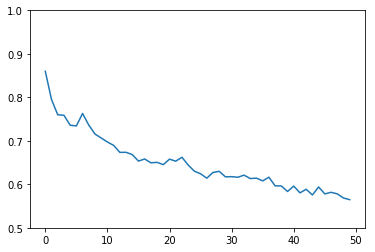

In [20]:
plt.plot(test_accuracies)
plt.ylim(ymin=0.5, ymax=1)
plt.show()

In [19]:
print(np.mean(test_accuracies))

0.649449127265404


(array([1.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        5.000e+00, 5.000e+00, 8.000e+00, 1.700e+01, 1.300e+01, 2.000e+01,
        2.800e+01, 4.600e+01, 5.200e+01, 8.100e+01, 9.400e+01, 9.700e+01,
        1.380e+02, 1.980e+02, 2.320e+02, 2.840e+02, 3.510e+02, 4.340e+02,
        5.420e+02, 6.330e+02, 7.070e+02, 7.310e+02, 8.240e+02, 9.230e+02,
        9.230e+02, 1.031e+03, 9.850e+02, 1.187e+03, 1.148e+03, 1.110e+03,
        1.244e+03, 1.328e+03, 1.330e+03, 1.351e+03, 1.380e+03, 1.352e+03,
        1.363e+03, 1.407e+03, 1.334e+03, 1.345e+03, 1.313e+03, 1.332e+03,
        1.317e+03, 1.288e+03, 1.219e+03, 1.178e+03, 1.145e+03, 1.137e+03,
        1.043e+03, 9.510e+02, 9.990e+02, 9.580e+02, 8.370e+02, 7.770e+02,
        7.030e+02, 6.530e+02, 5.880e+02, 5.490e+02, 4.400e+02, 4.000e+02,
        3.320e+02, 3.110e+02, 2.390e+02, 1.900e+02, 1.810e+02, 1.440e+02,
        1.260e+02, 1.070e+02, 8.800e+01, 6.400e+01, 5.600e+01, 3.200e+01,
        2.300e+01, 1.500e+01, 1.100e+0

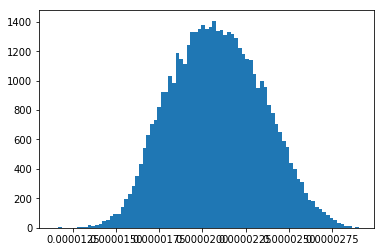

In [21]:
plt.hist(tuner.appended_task_list[-1].train.weights[0 : tuner.appended_task_list[-2].train.weights.shape[0]], bins='auto')

In [ ]:
if use_tpu:
    sess.run(tpu.shutdown_system())

sess.close()

In [ ]:
import shelve
filename='code_state.bak'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()